In [5]:
!pip install ipykernel


   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ------------------- -------------------- 2.6/5.3 MB 13.7 MB/s eta 0:00:01
   ---------------------------------------  5.2/5.3 MB 13.9 MB/s eta 0:00:01
   ---------------------------------------- 5.3/5.3 MB 12.3 MB/s eta 0:00:00


In [5]:
!python -m ipykernel install --user --name=desired_env --display-name "Python (ml_study)"


Installed kernelspec desired_env in C:\Users\user\AppData\Roaming\jupyter\kernels\desired_env


In [6]:
!pip install --upgrade scikit-learn


In [21]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [22]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
# extra libraries
from scipy import stats
from scipy.stats import f_oneway, skew
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.neural_network import MLPRegressor



In [23]:
import sklearn
sklearn.__version__

'1.6.1'

In [24]:
def wrangle(path, scaling=False):
    df=pd.read_csv(path)
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df.drop(columns=['unnamed'], inplace=True)
    # Impute missing values
    
    # Derive column 'Brand' from column: 'title'
    df.insert(1, "brand", df.apply(lambda row : row["title"].split(" ")[0].upper(), axis=1))
    # drop title column
    df = df.drop(columns=['title'])
    # Fill in Service History
    df['service_history']=df['service_history'].fillna('unknown')
    # fill in with median
    df['previous_owners'].fillna(df['previous_owners'].median(), inplace=True)
    df['doors'].fillna(df['doors'].median(), inplace=True)
    df['seats'].fillna(df['seats'].median(), inplace=True)
    # Fill missing 'emission_class' values with the most frequent category (mode)
    df['engine']=df['engine'].fillna(df['engine'].mode()[0])
    df['emission_class']=df['emission_class'].fillna(df['emission_class'].mode()[0]) 
    # put all the contents in to lower case
    categorical = list(df.dtypes[df.dtypes == 'object'].index)
    numerical = list(df.dtypes[df.dtypes != 'object'].index)
    for col in categorical:
        df[col] = df[col].str.lower().str.replace(' ', '_')
    
    
        
    
    
    
    

    return df

In [25]:
df = pd.read_csv('./data/used_cars_UK.csv')

In [26]:
df.head()

,Unnamed: 0,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history
0,0,SKODA Fabia,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,1,Vauxhall Corsa,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,2,Hyundai i30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,3,MINI Hatch,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,4,Vauxhall Corsa,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3685 entries, 0 to 3684
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3685 non-null   int64  
 1   title              3685 non-null   object 
 2   Price              3685 non-null   int64  
 3   Mileage(miles)     3685 non-null   int64  
 4   Registration_Year  3685 non-null   int64  
 5   Previous Owners    2276 non-null   float64
 6   Fuel type          3685 non-null   object 
 7   Body type          3685 non-null   object 
 8   Engine             3640 non-null   object 
 9   Gearbox            3685 non-null   object 
 10  Doors              3660 non-null   float64
 11  Seats              3650 non-null   float64
 12  Emission Class     3598 non-null   object 
 13  Service history    540 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 403.2+ KB


In [28]:
df.columns.to_list()

['Unnamed: 0',
 'title',
 'Price',
 'Mileage(miles)',
 'Registration_Year',
 'Previous Owners',
 'Fuel type',
 'Body type',
 'Engine',
 'Gearbox',
 'Doors',
 'Seats',
 'Emission Class',
 'Service history']

In [29]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [30]:
df.head()

,unnamed:_0,title,price,mileage(miles),registration_year,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class,service_history
0,0,SKODA Fabia,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,1,Vauxhall Corsa,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,2,Hyundai i30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,3,MINI Hatch,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,4,Vauxhall Corsa,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


<div style="background-color:#00008b;font-size:40px; color:white;">Data Exploration</div>

In [31]:
# Check all the values
df.describe().T

,count,mean,std,min,25%,50%,75%,max
unnamed:_0,3685.0,2314.770963,1415.821308,0.0,1059.0,2279.0,3593.0,4727.0
price,3685.0,5787.145726,4480.810572,400.0,2490.0,4000.0,7995.0,33900.0
mileage(miles),3685.0,81328.164722,39420.833595,1.0,56984.0,80000.0,103000.0,1110100.0
registration_year,3685.0,2011.835007,5.092566,1953.0,2008.0,2012.0,2015.0,2023.0
previous_owners,2276.0,2.807557,1.546028,1.0,2.0,3.0,4.0,9.0
doors,3660.0,4.321038,0.986902,2.0,3.0,5.0,5.0,5.0
seats,3650.0,4.900274,0.577200,2.0,5.0,5.0,5.0,7.0


In [32]:
len(list(df.engine.unique()))

35

In [33]:
df.engine.unique()

array(['1.4L', '1.2L', '1.3L', '2.0L', '1.6L', '2.3L', '1.8L', '1.0L',
       '3.0L', '1.5L', '1.9L', '2.4L', '2.2L', '3.5L', '3.2L', '2.5L',
       '1.1L', '3.1L', '3.7L', '2.6L', '2.1L', '2.8L', '5.0L', '0.8L',
       '2.7L', '1.7L', '0.9L', '4.2L', nan, '4.4L', '4.3L', '3.3L',
       '5.5L', '4.8L', '6.3L'], dtype=object)

In [34]:
# Columns with Null Values
df.isnull().sum()[df.isnull().sum()!=0]

previous_owners    1409
engine               45
doors                25
seats                35
emission_class       87
service_history    3145
dtype: int64

In [35]:
df.isnull().sum()/len(df)

unnamed:_0           0.000000
title                0.000000
price                0.000000
mileage(miles)       0.000000
registration_year    0.000000
previous_owners      0.382361
fuel_type            0.000000
body_type            0.000000
engine               0.012212
gearbox              0.000000
doors                0.006784
seats                0.009498
emission_class       0.023609
service_history      0.853460
dtype: float64

In [36]:
# Columns with Null Values
df.isnull().sum()[df.isnull().sum()!=0].index

Index(['previous_owners', 'engine', 'doors', 'seats', 'emission_class',
       'service_history'],
      dtype='object')

In [37]:
# Fill in Service History
df['service_history']=df['service_history'].fillna('unknown')

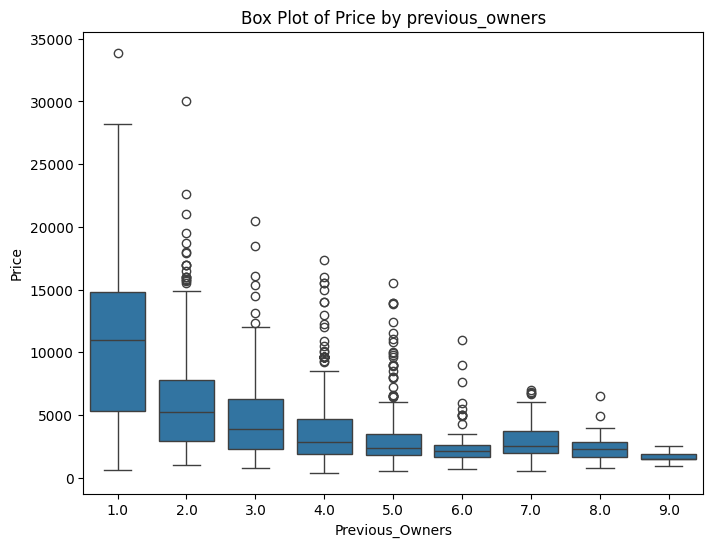

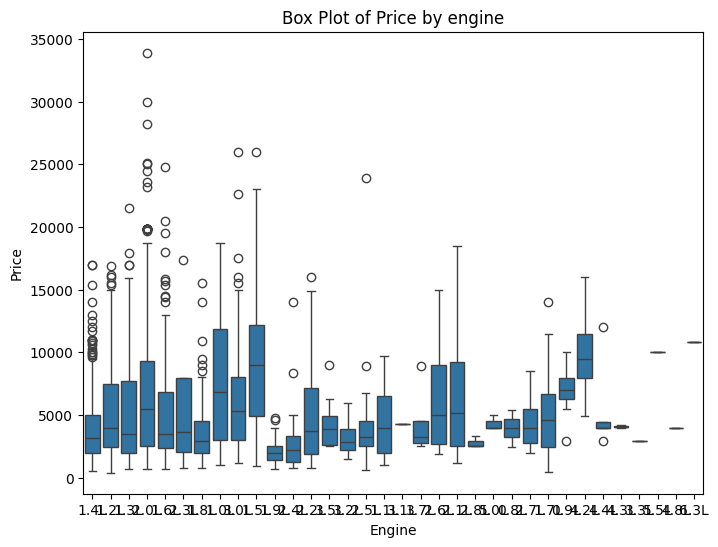

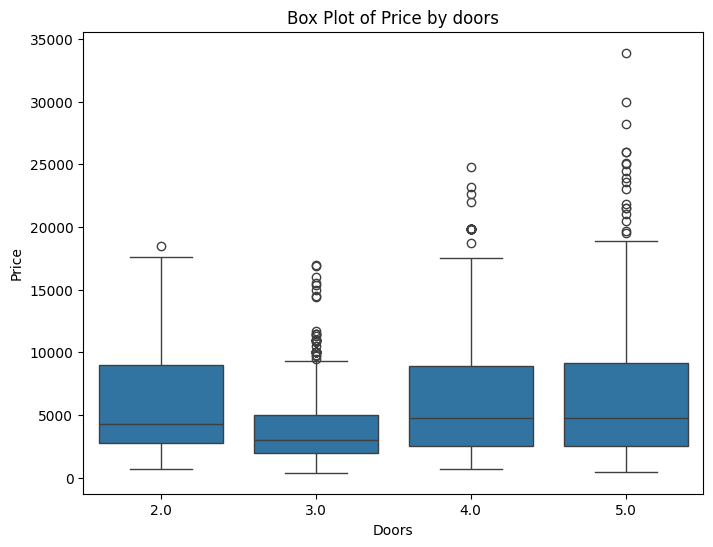

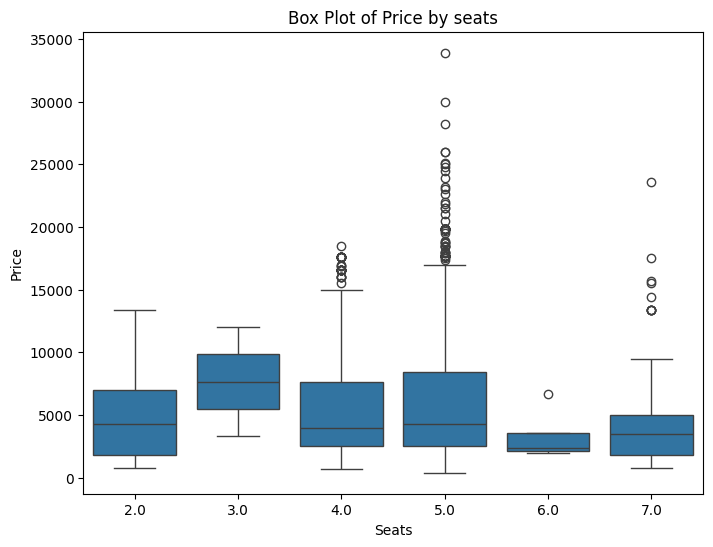

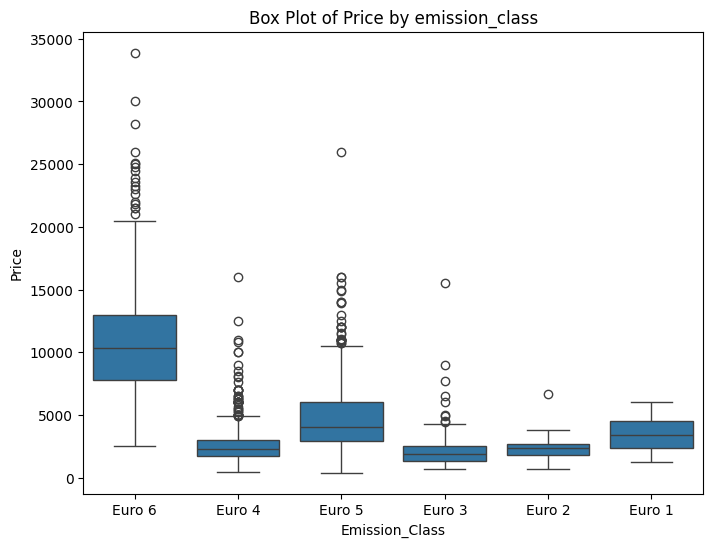

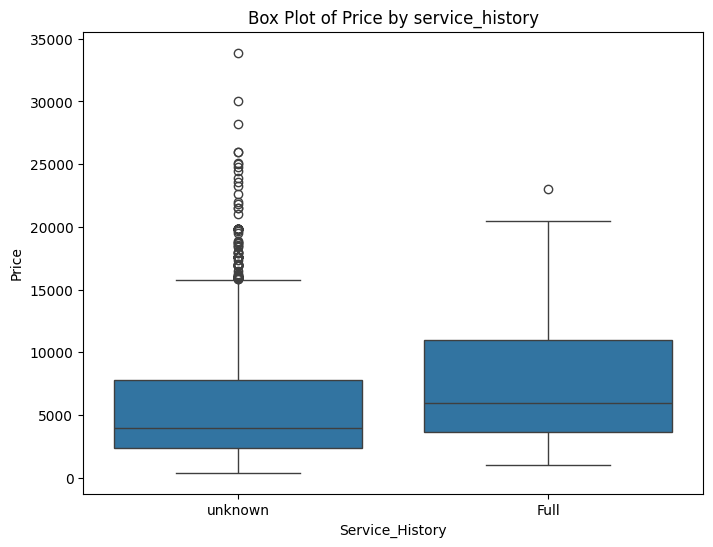

In [38]:
missing_cols=['previous_owners', 'engine', 'doors', 'seats', 'emission_class','service_history']

for col in missing_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=col, y='price', data=df)
    plt.xlabel(col.title())
    plt.ylabel('Price')
    plt.title(f'Box Plot of Price by {col}')
    plt.show()


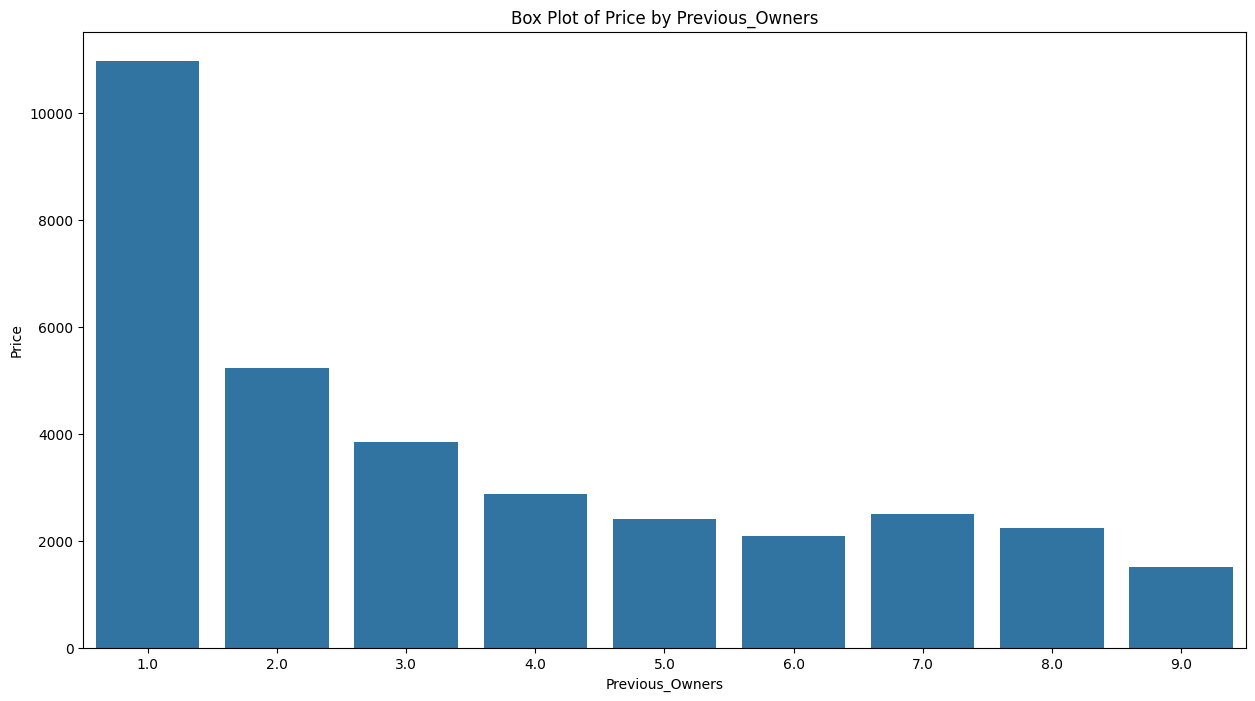

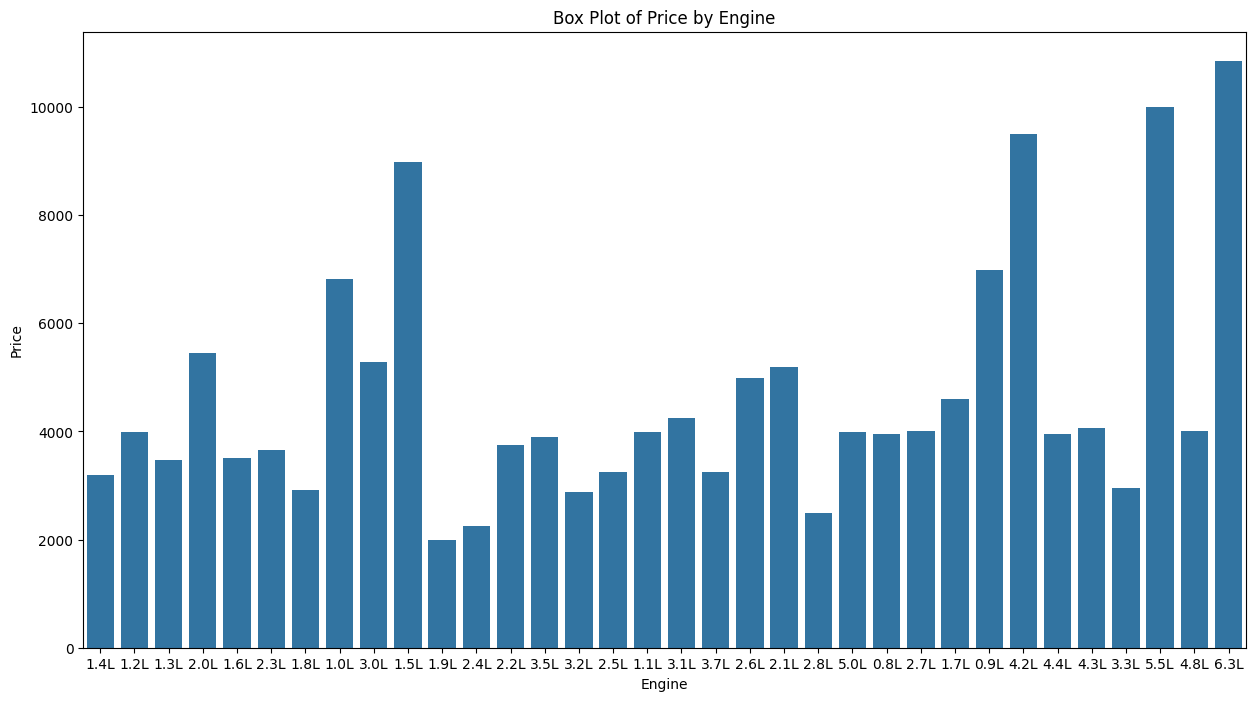

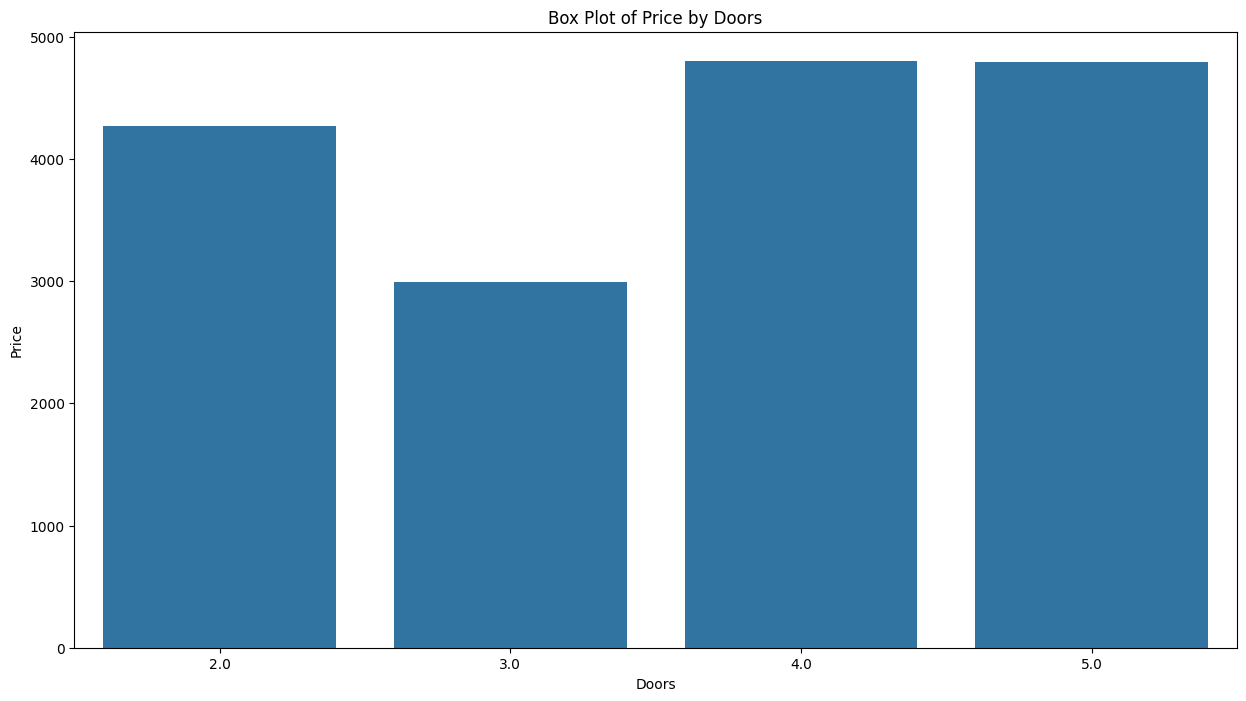

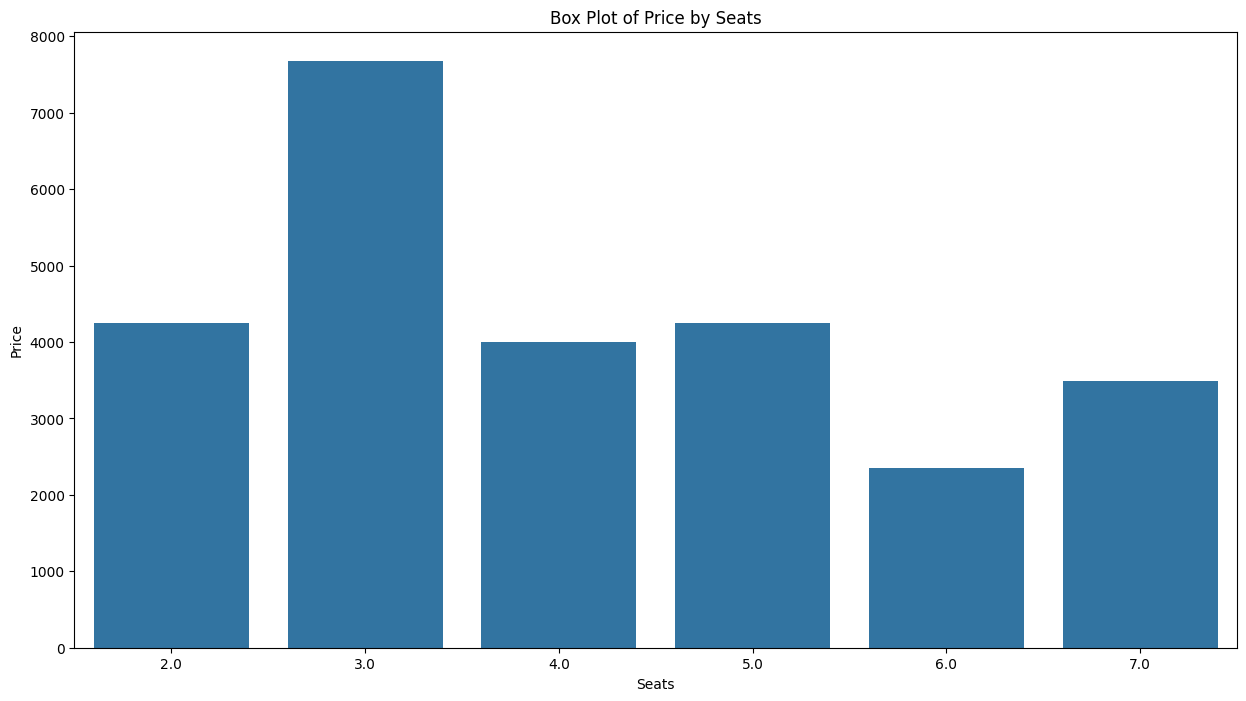

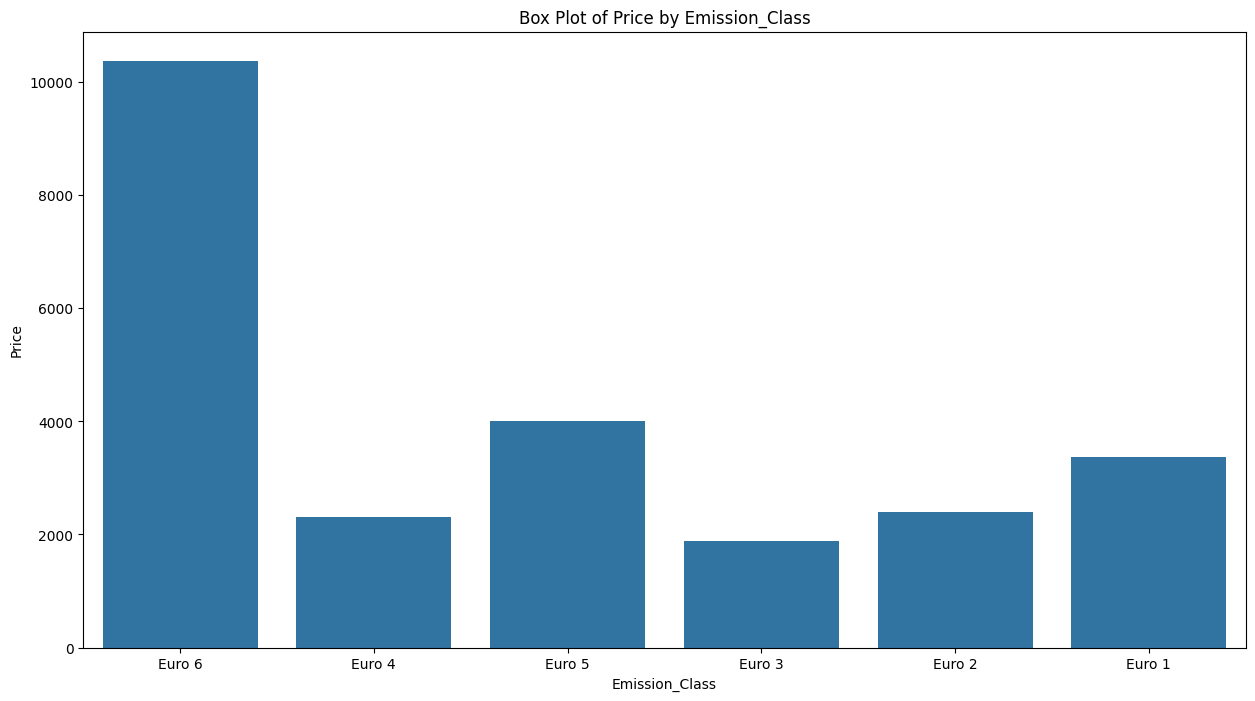

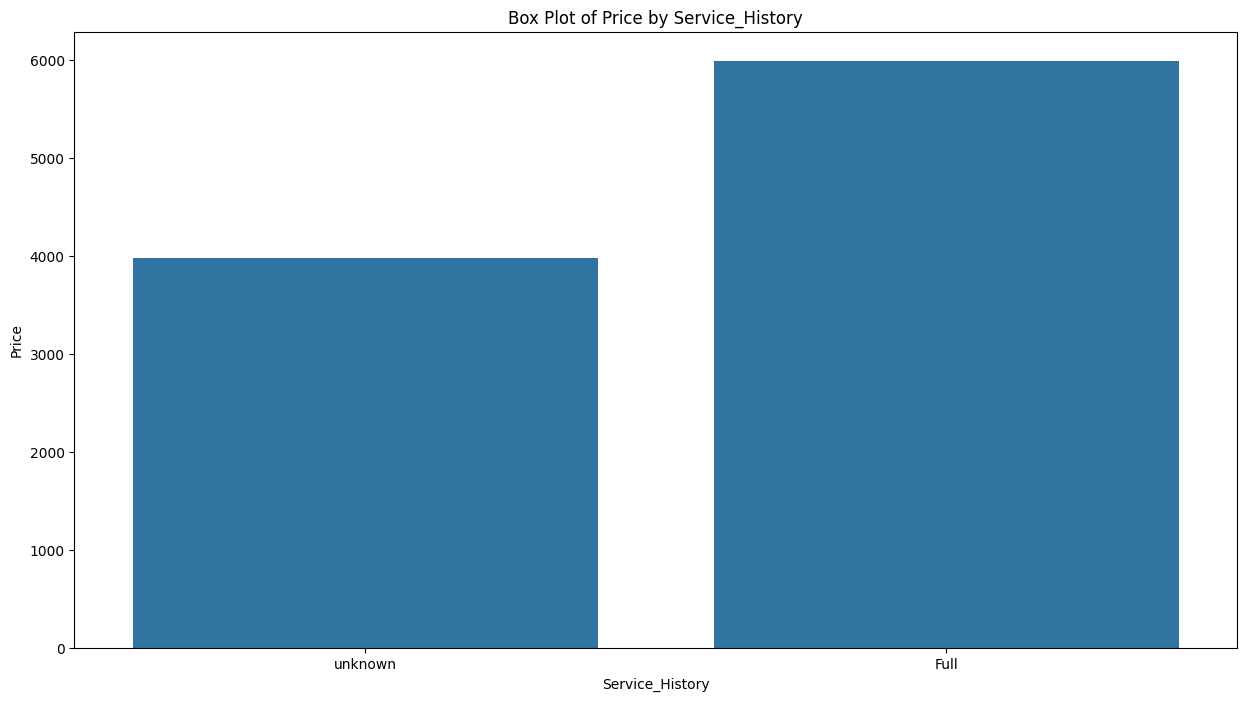

In [39]:
missing_cols=['previous_owners', 'engine', 'doors', 'seats', 'emission_class','service_history']

for col in missing_cols:
    plt.figure(figsize=(15, 8))
    sns.barplot(x=col, y='price', data=df, estimator='median', errorbar=None)
    plt.xlabel(col.title())
    plt.ylabel('Price')
    plt.title(f'Box Plot of Price by {col.title()}')
    plt.show()


In [40]:
# Service History has 85% missing and unamed is just an extra column, so both dropped
df.drop(['unnamed:_0'], axis=1, inplace=True)

In [41]:
df.head()

,title,price,mileage(miles),registration_year,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class,service_history
0,SKODA Fabia,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,unknown
1,Vauxhall Corsa,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,Hyundai i30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,unknown
3,MINI Hatch,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,Vauxhall Corsa,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,unknown


In [42]:
# Impute missing values


In [43]:
# columns with missing values
# Columns with Null Values
missing_cols=df.isnull().sum()[df.isnull().sum()!=0].index.to_list()
print(missing_cols)
# drop categorical missing columns
# drop engine
del missing_cols[1]
# drop emission_class
del missing_cols[3]

['previous_owners', 'engine', 'doors', 'seats', 'emission_class']


In [44]:
missing_cols

['previous_owners', 'doors', 'seats']

previous_owners Skewness: 0.8450023547312594


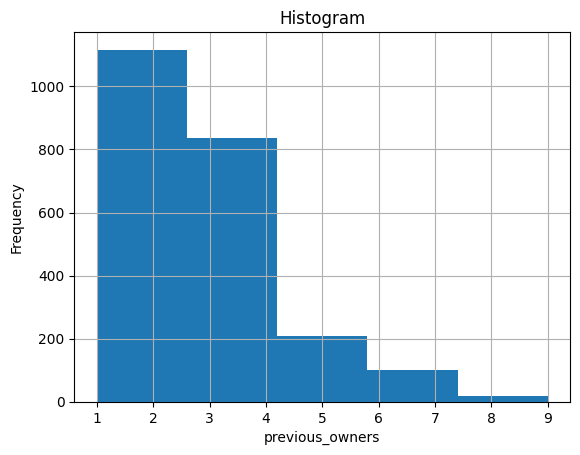

doors Skewness: -1.0453034112289992


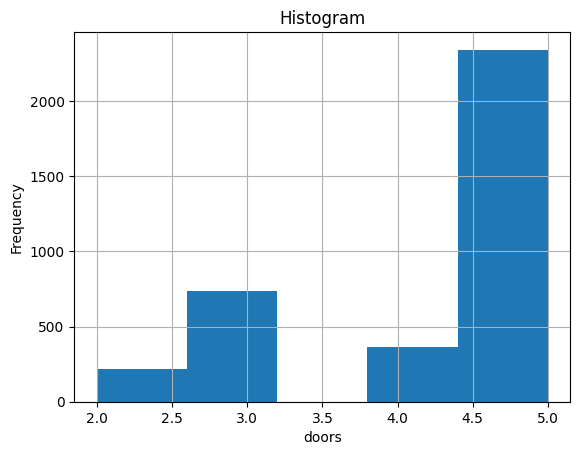

seats Skewness: 0.16730060071794964


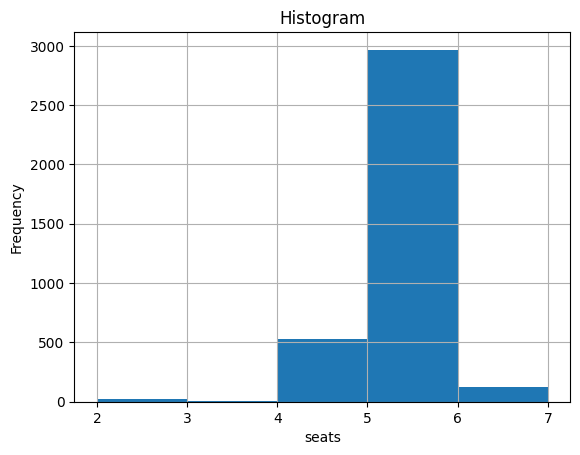

In [45]:
# Visualise the distribution
for col in missing_cols:
    # Plot histogram
    df[col].hist(bins=5)
    plt.title("Histogram")
    skewness = df[col].skew()
    print(f"{col} Skewness: {skewness}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

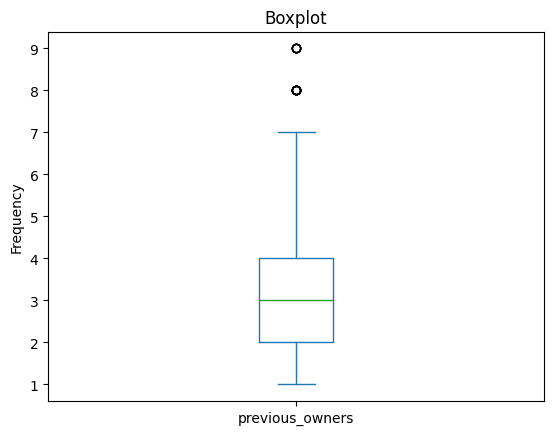

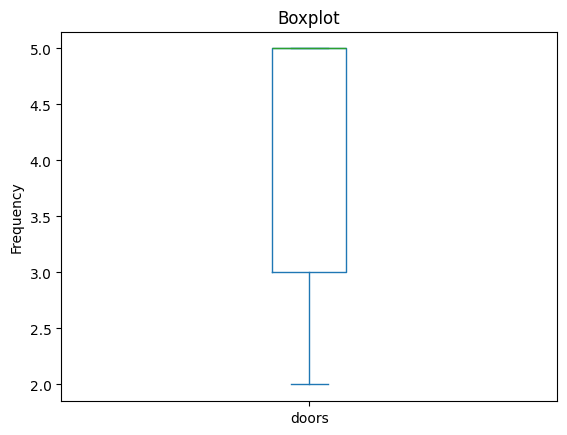

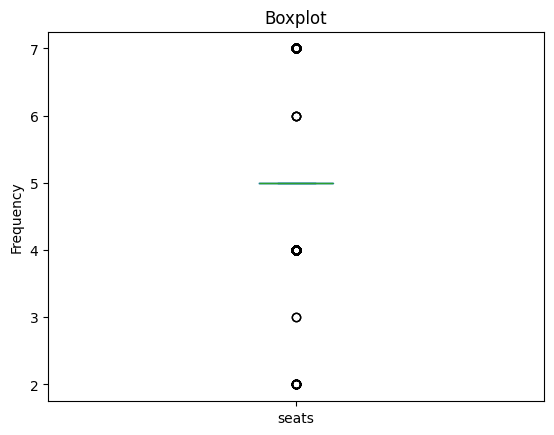

In [46]:
# Visualise the distribution
for col in missing_cols:
    # Plot histogram
    df[col].plot(kind='box')
    plt.title("Boxplot")
    plt.ylabel("Frequency")
    plt.show()

In [47]:
# Check skewness and fill missing values with median if skewed
skewness=df[missing_cols].skew()
for column in missing_cols:
    if skewness[column] > 0.5:  # Right skewed
        print(f"{column} is positively skewed. Filling missing values with the median.")
        df[column].fillna(df[column].median(), inplace=True)
    elif skewness[column] < -0.5:  # Left skewed
        print(f"{column} is negatively skewed. Filling missing values with the median.")
        df[column].fillna(df[column].median(), inplace=True)
    else:
        print(f"{column} is not significantly skewed. Filling missing values with the median.")
        df[column].fillna(df[column].median(), inplace=True)

previous_owners is positively skewed. Filling missing values with the median.
doors is negatively skewed. Filling missing values with the median.
seats is not significantly skewed. Filling missing values with the median.


In [48]:
# Fill missing 'emission_class' values with the most frequent category (mode)
df['engine']=df['engine'].fillna(df['engine'].mode()[0])
df['emission_class']=df['emission_class'].fillna(df['emission_class'].mode()[0])

In [49]:
df.isnull().sum()

title                0
price                0
mileage(miles)       0
registration_year    0
previous_owners      0
fuel_type            0
body_type            0
engine               0
gearbox              0
doors                0
seats                0
emission_class       0
service_history      0
dtype: int64

In [50]:
df.duplicated().sum()

np.int64(826)

In [51]:
df.drop_duplicates(inplace=True)

In [52]:
df.shape

(2859, 13)

In [53]:
df.tail()

,title,price,mileage(miles),registration_year,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class,service_history
3680,Renault Megane,1395,76202,2006,4.0,Petrol,Hatchback,1.6L,Manual,5.0,5.0,Euro 4,unknown
3681,Audi A4,6990,119000,2012,3.0,Petrol,Saloon,2.0L,Manual,4.0,5.0,Euro 5,unknown
3682,BMW 3 Series,3995,139000,2013,3.0,Diesel,Saloon,2.0L,Manual,4.0,5.0,Euro 5,unknown
3683,Honda Accord,1390,179190,2007,3.0,Diesel,Estate,2.2L,Manual,5.0,5.0,Euro 4,Full
3684,Vauxhall Corsa,2000,82160,2013,7.0,Petrol,Hatchback,1.2L,Manual,5.0,5.0,Euro 5,unknown


### Unique Values in Categorical Features

In [54]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

title
['SKODA Fabia' 'Vauxhall Corsa' 'Hyundai i30' 'MINI Hatch' 'Hyundai Coupe']
469

price
[6900 1495  949 2395 1000]
866

mileage(miles)
[ 70189  88585 137000  96731  85000]
1570

registration_year
[2016 2008 2011 2010 2013]
40

previous_owners
[3. 4. 5. 1. 2.]
9

fuel_type
['Diesel' 'Petrol' 'Petrol Plug-in Hybrid' 'Petrol Hybrid' 'Electric']
6

body_type
['Hatchback' 'Coupe' 'Estate' 'Saloon' 'Convertible']
10

engine
['1.4L' '1.2L' '1.3L' '2.0L' '1.6L']
34

gearbox
['Manual' 'Automatic']
2

doors
[5. 3. 4. 2.]
4

seats
[5. 4. 2. 7. 3.]
6

emission_class
['Euro 6' 'Euro 4' 'Euro 5' 'Euro 3' 'Euro 2']
6

service_history
['unknown' 'Full']
2



### Checking for Outliers

In [55]:
### Skewness check for price
# Calculate skewness
skewness = df['price'].skew()
print(f"Price Skewness: {skewness}")

Price Skewness: 1.6794462567163226


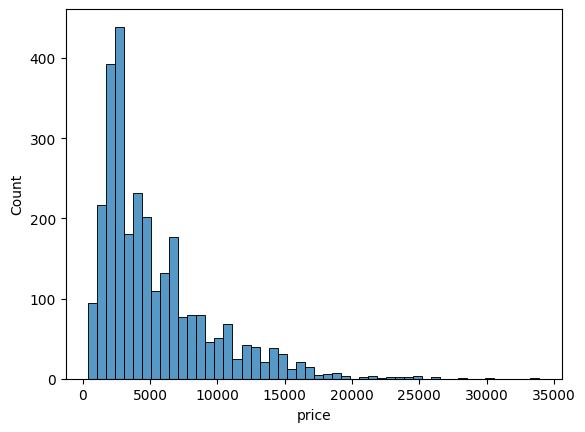

In [56]:
sns.histplot(df.price, bins=50)
plt.savefig('price_dist');

In [57]:
# Transforming to deal with skewness
price_logs = np.log1p(df.price)
price_logs.skew()  # no skewness

np.float64(0.04795827650688819)

<Axes: xlabel='price', ylabel='Count'>

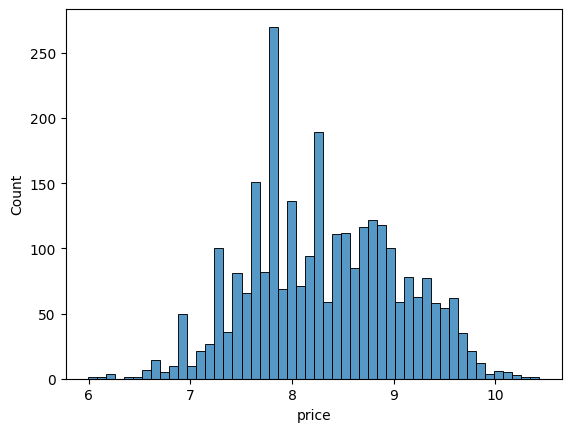

In [58]:
sns.histplot(price_logs, bins=50)

### Feature Engineering

In [59]:
# Derive column 'Brand' from column: 'title'
df.insert(1, "brand", df.apply(lambda row : row["title"].split(" ")[0].upper(), axis=1))
# drop title column
df = df.drop(columns=['title'])

In [60]:
### Converting engine size to numerical feature

In [61]:
# # Derive column 'engine_size' from column: 'engine'
# df.insert(7, "engine_size", df.apply(lambda row : row["engine"].split("L")[0].upper(), axis=1))
# # drop title column
# # Step 2: Convert the 'engine_size' column to float
# df["engine_size"] = df["engine_size"].astype(float)
# df = df.drop(columns=['engine'])

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2859 entries, 0 to 3684
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              2859 non-null   object 
 1   price              2859 non-null   int64  
 2   mileage(miles)     2859 non-null   int64  
 3   registration_year  2859 non-null   int64  
 4   previous_owners    2859 non-null   float64
 5   fuel_type          2859 non-null   object 
 6   body_type          2859 non-null   object 
 7   engine             2859 non-null   object 
 8   gearbox            2859 non-null   object 
 9   doors              2859 non-null   float64
 10  seats              2859 non-null   float64
 11  emission_class     2859 non-null   object 
 12  service_history    2859 non-null   object 
dtypes: float64(3), int64(3), object(7)
memory usage: 312.7+ KB


In [63]:
df.brand.nunique()

48

In [64]:
# df['age'] =2023 - df['registration_year']
# df.drop(columns=['registration_year'], inplace=True)


In [65]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = [x for x in list(df.dtypes[df.dtypes != 'object'].index) if x !='price']
numerical, categorical

(['mileage(miles)', 'registration_year', 'previous_owners', 'doors', 'seats'],
 ['brand',
  'fuel_type',
  'body_type',
  'engine',
  'gearbox',
  'emission_class',
  'service_history'])

In [66]:
for col in categorical:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [67]:
len(categorical + numerical)

12

In [68]:
numerical

['mileage(miles)', 'registration_year', 'previous_owners', 'doors', 'seats']

<div style="background-color:#00008b;font-size:40px; color:white;">Correlation</div>

### Numerical Features with Price

mileage(miles)


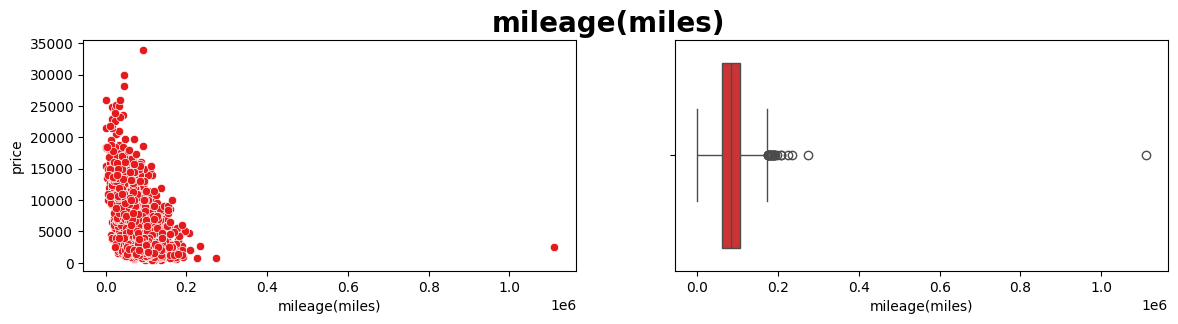

registration_year


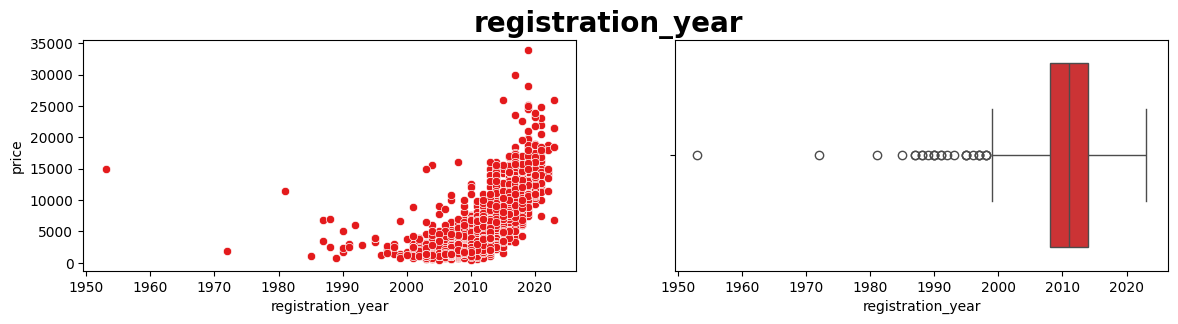

previous_owners


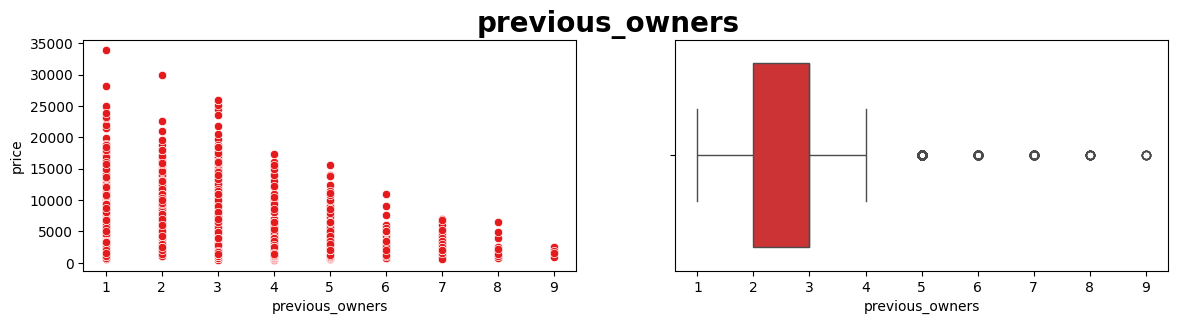

doors


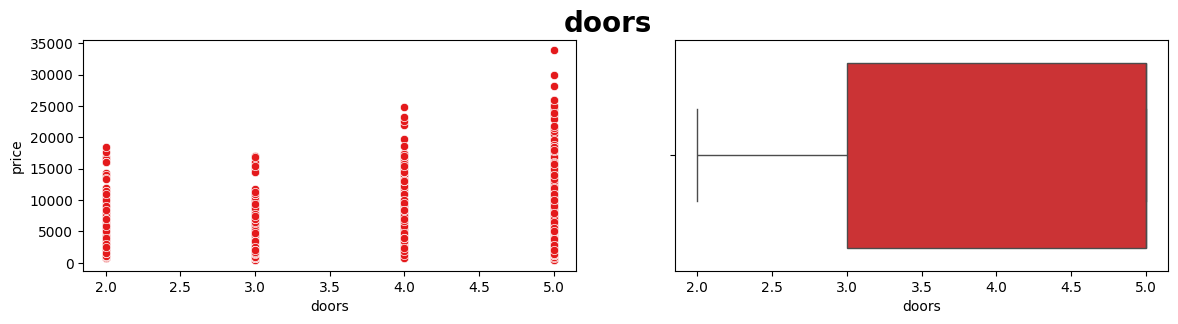

seats


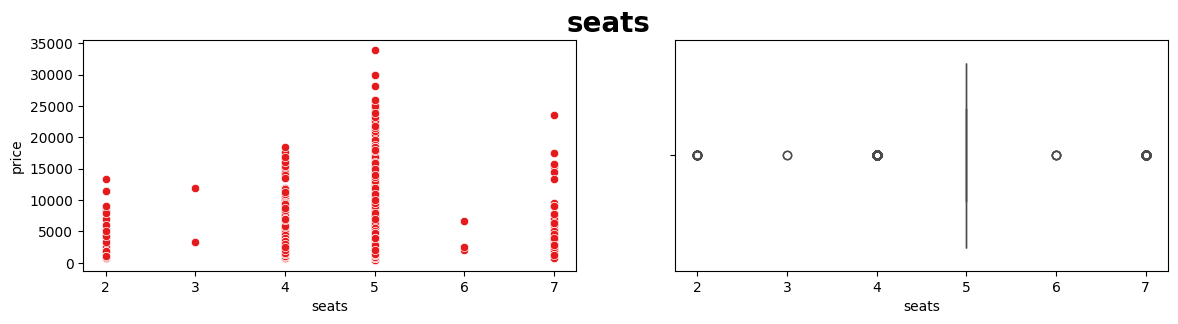

In [69]:

for feature in numerical:
    print(feature)
    fig = plt.figure(figsize=(14, 3))
    sns.set_palette("Set1")
    plt.suptitle(feature, size=20, weight='bold')
    
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=feature, y='price', data=df)
    
    plt.subplot(1, 2, 2)
    ax = sns.boxplot(x=feature, data=df)
    
    plt.show()

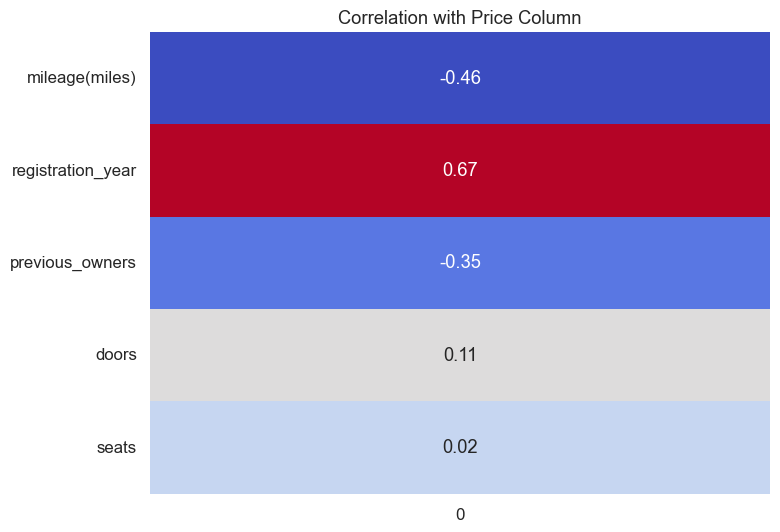

In [70]:
target_corr = df[numerical].corrwith(df['price'])

# Plot korelasi dengan heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.1)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr.to_frame(), cmap="coolwarm", annot=True, fmt='.2f', cbar=False)
plt.title('Correlation with Price Column')
plt.show()


### Categorical Features with Price

In [71]:
# condider having engine size as numerical after evaluating the model

brand


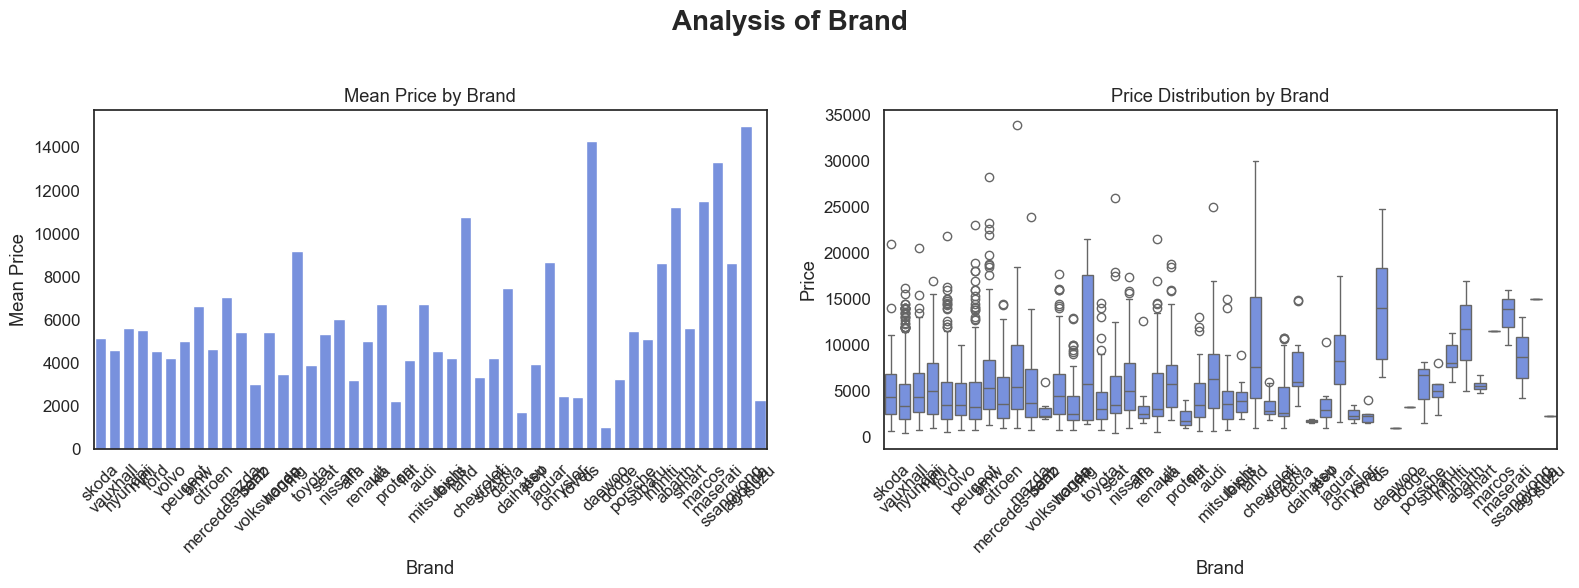

fuel_type


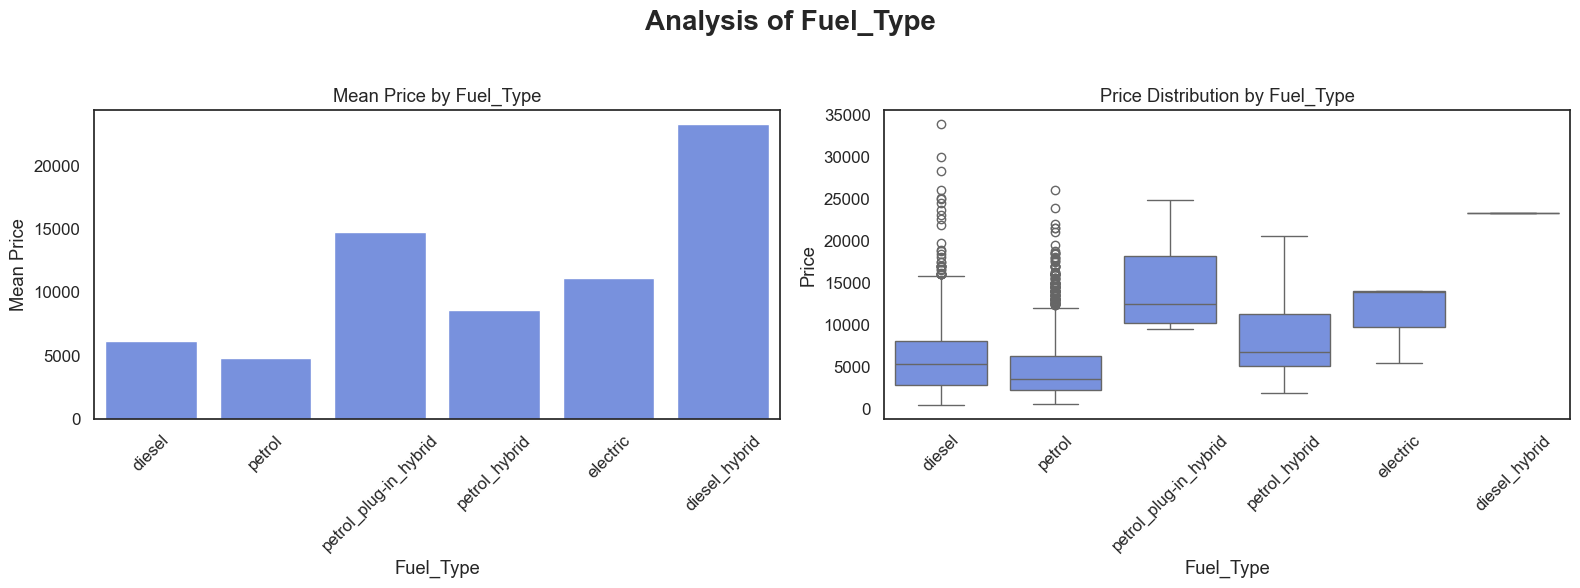

body_type


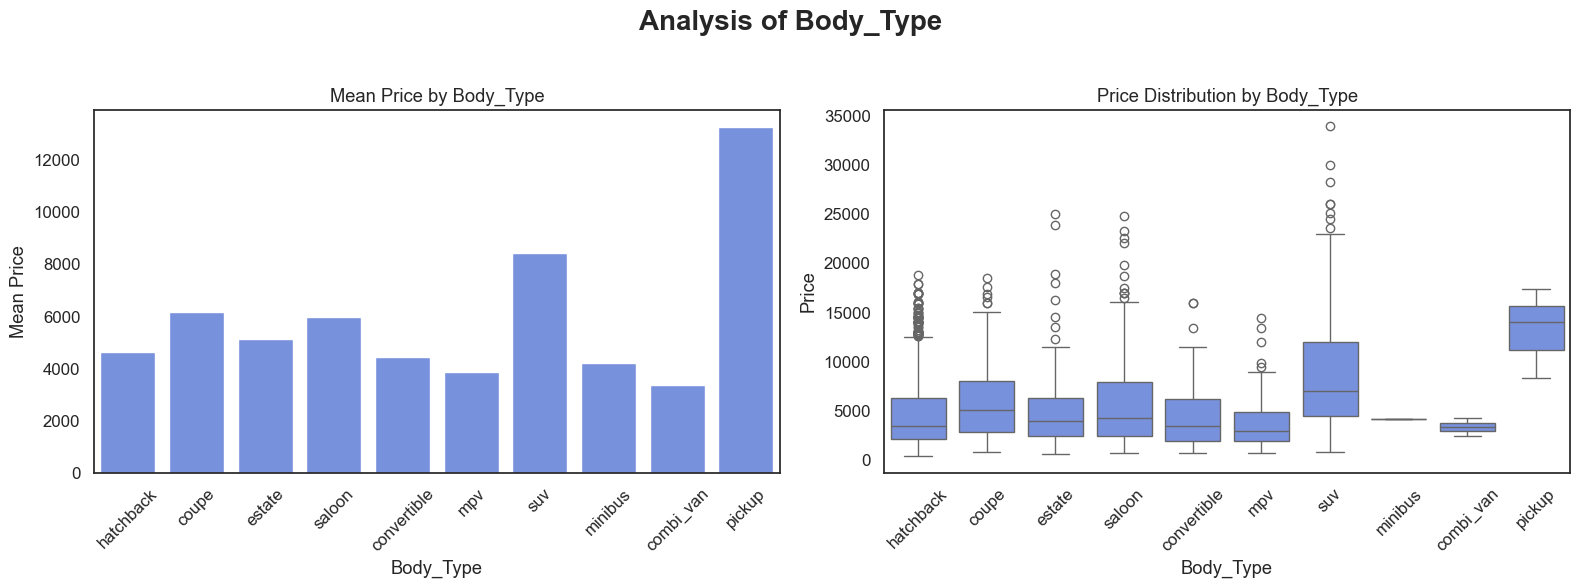

engine


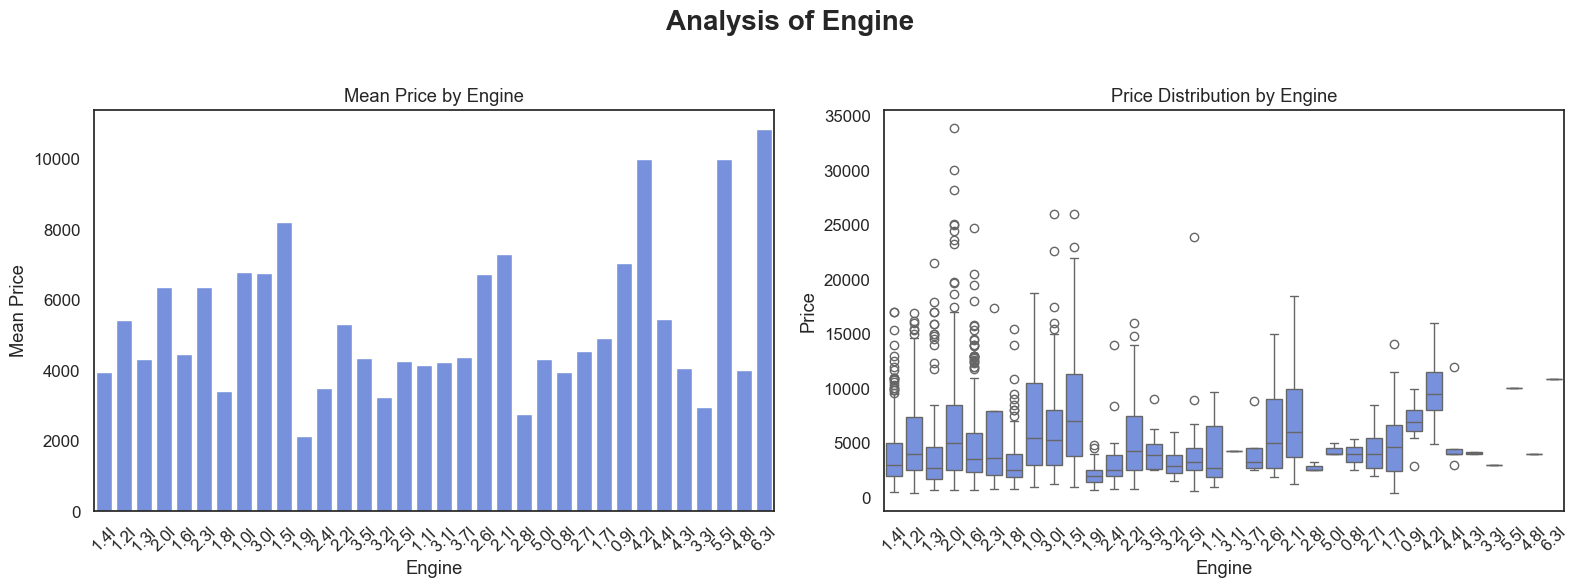

gearbox


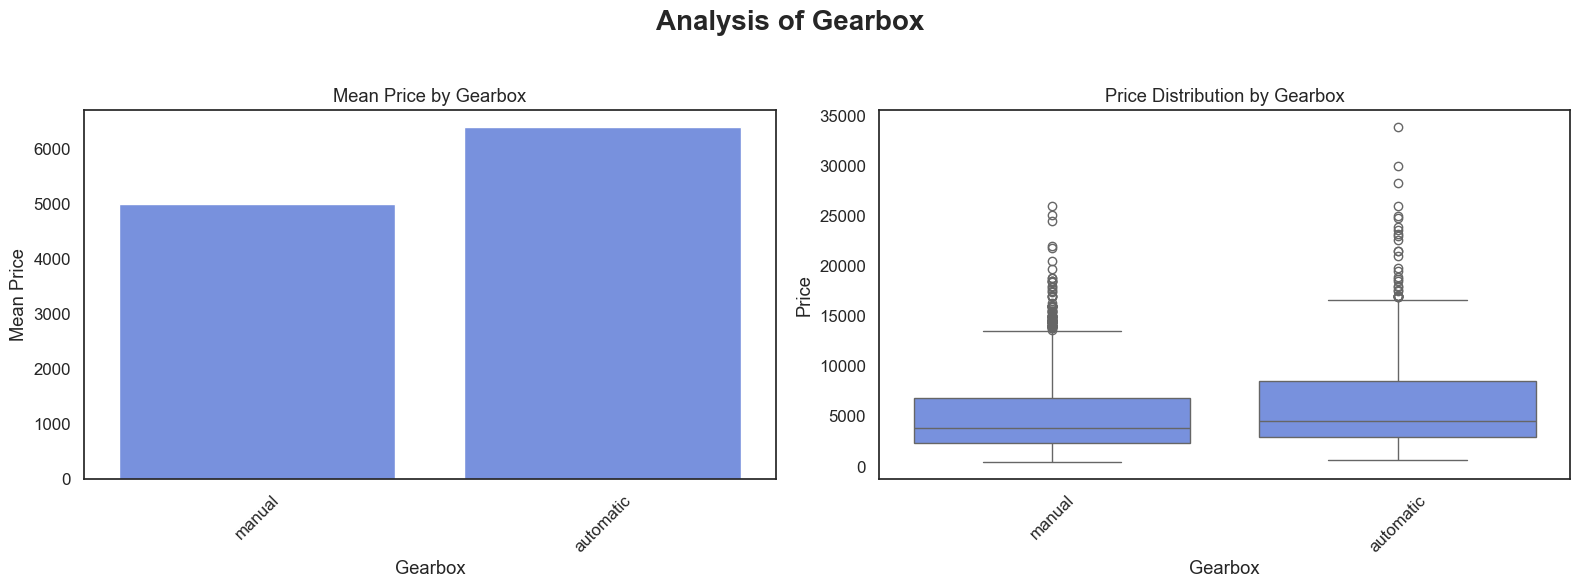

emission_class


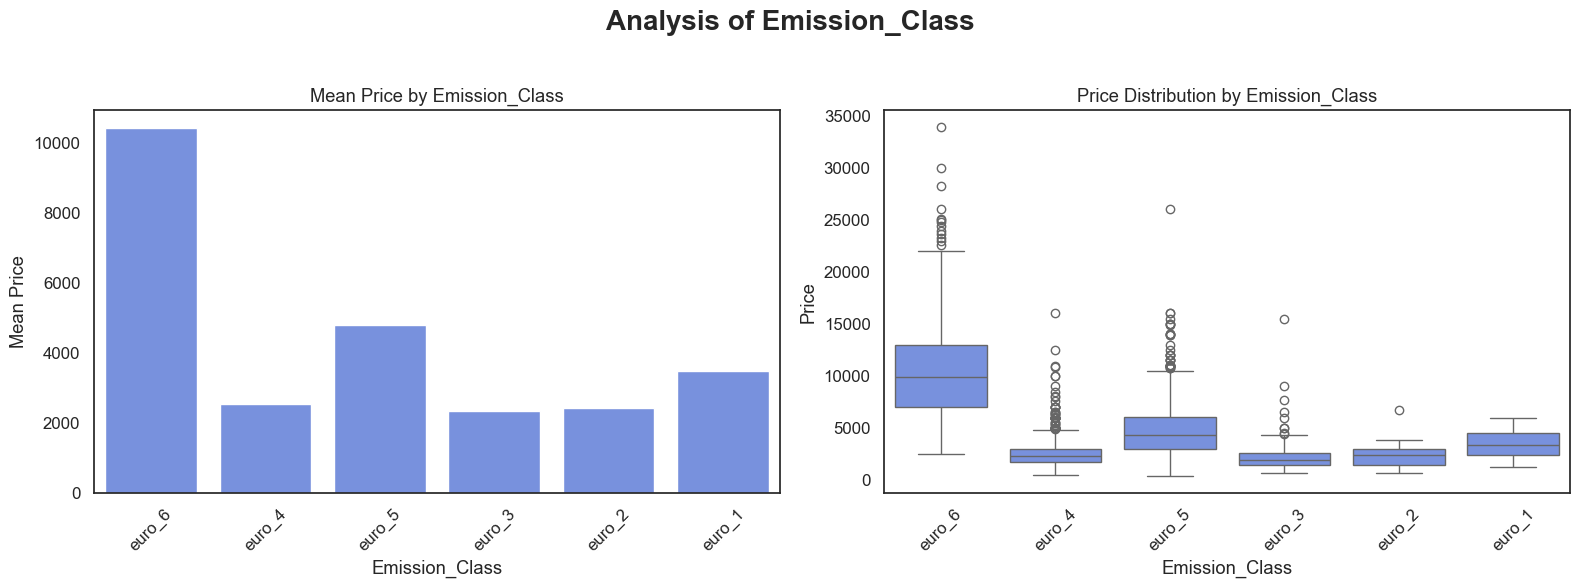

service_history


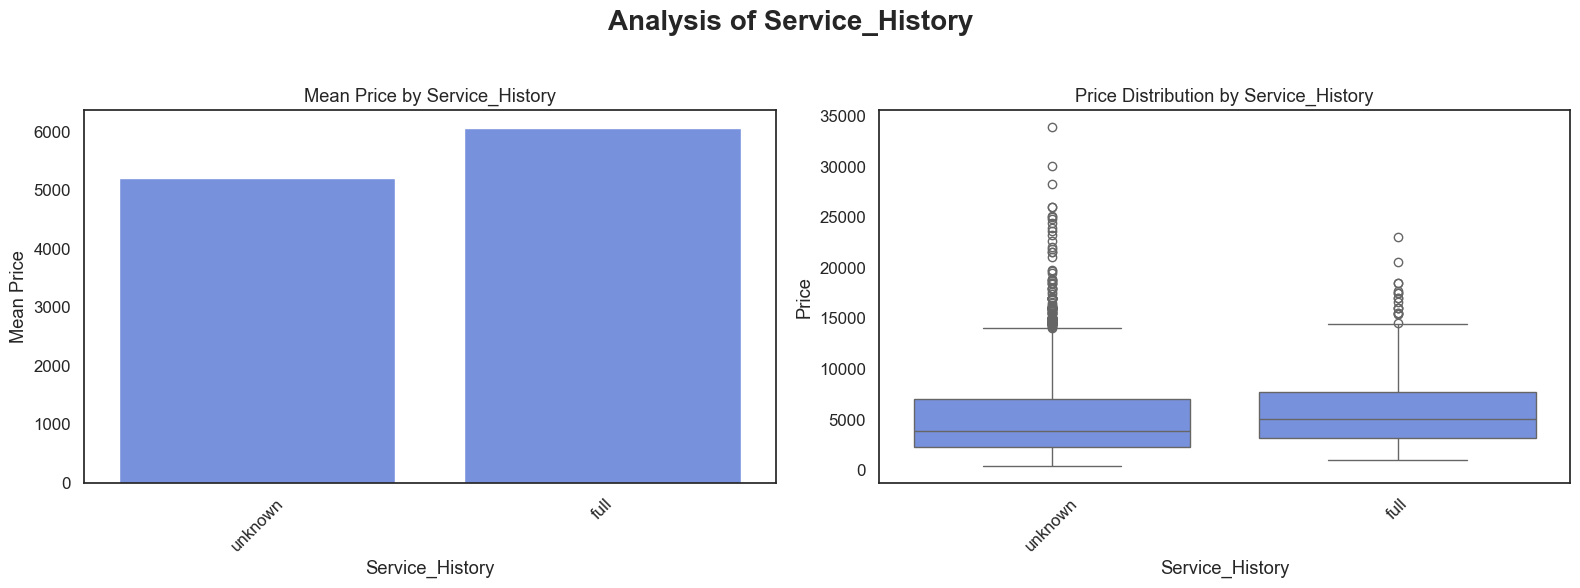

In [72]:
for feature in categorical:
    print(feature)
    fig = plt.figure(figsize=(16, 6))
    sns.set_palette("coolwarm")  # Change color palette to "coolwarm"
    plt.suptitle(f"Analysis of {feature.title()}", size=20, weight='bold')
    
    # First subplot: Barplot with mean price
    plt.subplot(1, 2, 1)
    sns.barplot(x=feature, y='price', data=df, errorbar=None, estimator=np.mean)
    plt.title(f"Mean Price by {feature.title()}")
    plt.xlabel(feature.title())
    plt.ylabel("Mean Price")
    plt.xticks(rotation=45)

    # Second subplot: Boxplot of price distribution
    plt.subplot(1, 2, 2)
    sns.boxplot(x=feature, y='price', data=df)
    plt.title(f"Price Distribution by {feature.title()}")
    plt.xlabel(feature.title())
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle
    plt.show()


In [73]:

def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((series < lower_bound) | (series > upper_bound)).sum()

for feature in numerical :
    num_outliers = count_outliers(df[feature])
    print(f'Number of outliers in {feature}: {num_outliers}')

Number of outliers in mileage(miles): 25
Number of outliers in registration_year: 26
Number of outliers in previous_owners: 281
Number of outliers in doors: 0
Number of outliers in seats: 539


In [74]:
df.tail()

,brand,price,mileage(miles),registration_year,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class,service_history
3680,renault,1395,76202,2006,4.0,petrol,hatchback,1.6l,manual,5.0,5.0,euro_4,unknown
3681,audi,6990,119000,2012,3.0,petrol,saloon,2.0l,manual,4.0,5.0,euro_5,unknown
3682,bmw,3995,139000,2013,3.0,diesel,saloon,2.0l,manual,4.0,5.0,euro_5,unknown
3683,honda,1390,179190,2007,3.0,diesel,estate,2.2l,manual,5.0,5.0,euro_4,full
3684,vauxhall,2000,82160,2013,7.0,petrol,hatchback,1.2l,manual,5.0,5.0,euro_5,unknown


### Correlation

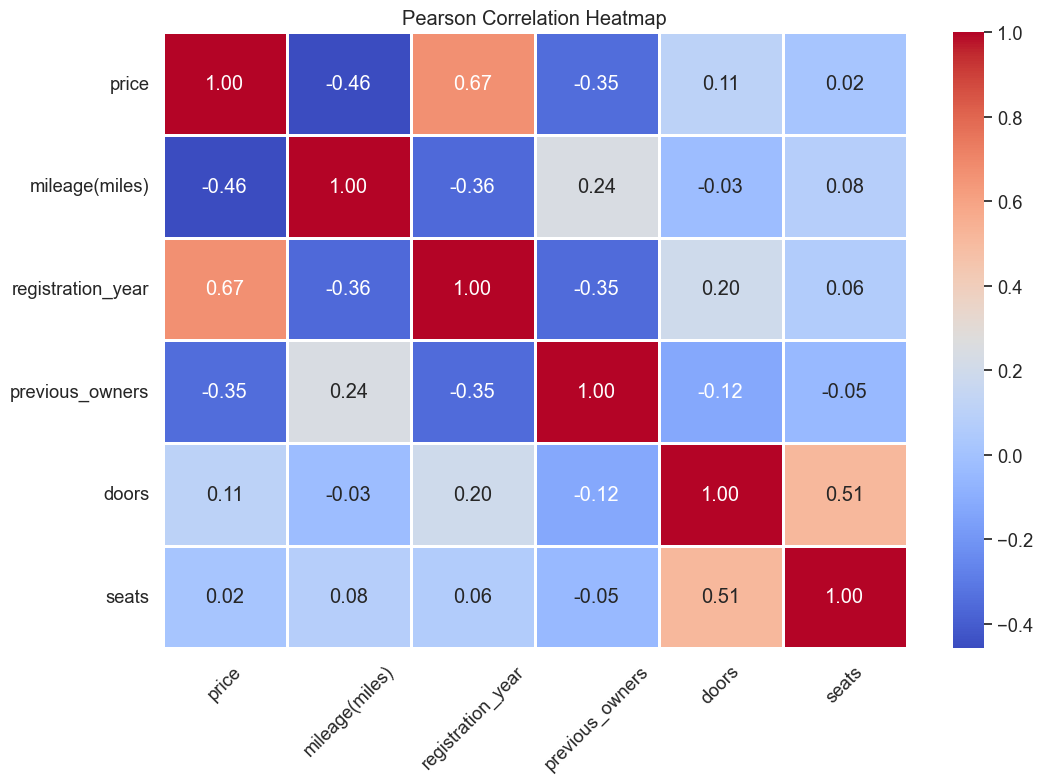

In [75]:
pearson_corr = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1, linecolor='white')
plt.title('Pearson Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

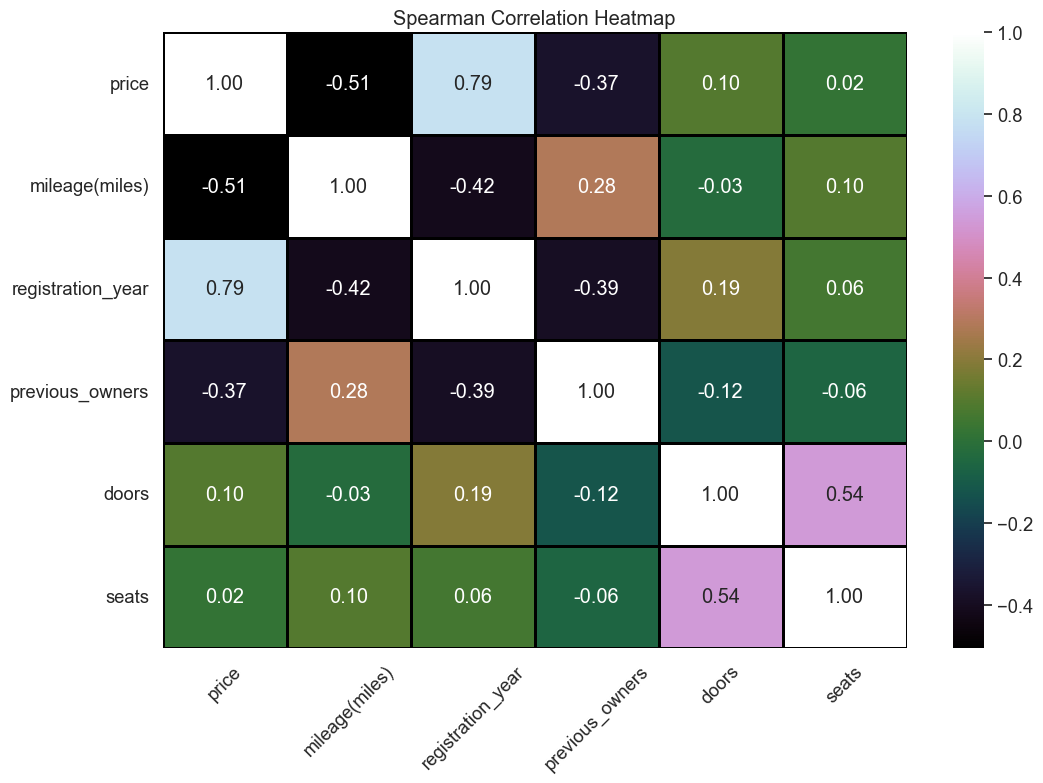

In [76]:
spearman_corr = df.corr(method='spearman', numeric_only=True)

plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)
sns.heatmap(spearman_corr, annot=True, cmap='cubehelix', fmt=".2f", linewidths=1, linecolor='black')
plt.title('Spearman Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## Categorical Encoding using One hot encoder

In [77]:
df.duplicated().sum()

np.int64(0)

In [78]:
duplicates = df[df.duplicated(keep=False)]
len(duplicates)

0

In [79]:
df.isnull().sum()

brand                0
price                0
mileage(miles)       0
registration_year    0
previous_owners      0
fuel_type            0
body_type            0
engine               0
gearbox              0
doors                0
seats                0
emission_class       0
service_history      0
dtype: int64

### Building Model 

#### Pipeline to combine dealing with categorical features, scaling and training.

In [80]:
# Define Feature Types
ordinal_features = ['service_history', 'emission_class', 'engine']
nominal_features = ['brand', 'fuel_type', 'body_type', 'gearbox']
numeric_features = ['mileage(miles)', 'registration_year', 'previous_owners', 'doors', 'seats'] 

# Define the full list of engine sizes
engine_sizes = ['0.8l', '0.9l', '1.0l', '1.1l', '1.2l', '1.3l', '1.4l', '1.5l', '1.6l', '1.7l', 
                '1.8l', '1.9l', '2.0l', '2.1l', '2.2l', '2.3l', '2.4l', '2.5l', '2.6l', '2.7l', 
                '2.8l', '2.9l', '3.0l', '3.1l', '3.2l', '3.3l', '3.5l', '3.7l', '4.0l', '4.2l', 
                '4.3l', '4.4l', '4.8l', '5.0l', '5.5l', '6.3l']


# Define Preprocessing Steps
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, categories=[
            ['unknown', 'full'],  # Service history categories
            ['euro_1', 'euro_2', 'euro_3', 'euro_4', 'euro_5', 'euro_6'],  # Emission class categories
            engine_sizes  # Full list of engine sizes
        ]), ordinal_features),
        
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'), nominal_features),
        
        ('scale', StandardScaler(), numeric_features)  # Scaling for numerical features
    ],
    remainder='drop'  # Drop any columns not specified
)








<div style="background-color:#00008b;font-size:40px; color:white;">  Split</div>


In [81]:
df.reset_index(inplace=True, drop=True)
X = df.drop('price', axis=1)
y=df.price
#y=np.log1p(df.price)
X.shape

(2859, 12)

In [82]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [83]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape

((1715, 12), (572, 12), (572, 12), (1715,))

In [84]:
X_train.emission_class.unique()

array(['euro_4', 'euro_5', 'euro_6', 'euro_2', 'euro_3', 'euro_1'],
      dtype=object)

In [122]:
X_train

,brand,mileage(miles),registration_year,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class,service_history
1738,ford,111741,2010,3.0,petrol,hatchback,1.8l,manual,5.0,5.0,euro_4,unknown
1376,mini,23752,2013,3.0,petrol,hatchback,1.6l,manual,3.0,4.0,euro_5,unknown
358,bmw,107800,2006,5.0,petrol,saloon,2.0l,automatic,4.0,5.0,euro_4,unknown
576,peugeot,52000,2009,4.0,petrol,hatchback,1.6l,manual,5.0,5.0,euro_4,unknown
1599,ford,60650,2019,1.0,petrol,hatchback,1.0l,manual,5.0,5.0,euro_6,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
673,kia,80000,2009,2.0,petrol,suv,1.6l,manual,5.0,5.0,euro_4,unknown
1545,nissan,81025,2009,3.0,petrol,hatchback,1.2l,manual,3.0,5.0,euro_4,unknown
1097,vauxhall,51000,2013,2.0,petrol,hatchback,1.2l,manual,3.0,5.0,euro_5,full
1733,honda,110000,2002,3.0,petrol,hatchback,1.4l,manual,5.0,5.0,euro_3,unknown


<div style="background-color:#00008b;font-size:40px; color:white;">Train</div>

## Base Model

In [111]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [112]:
y_mean=y_train.mean()
y_pred=[y_mean]*len(y_train)
RMSE=rmse(y_train, y_pred)
print(f'Root Mean Square Error {RMSE}')  # 4216

Root Mean Square Error 4064.0995144307326


In [113]:
mae = mean_absolute_error(y_train,y_pred)
print(f'MAE on train data: {mae}')

MAE on train data: 3101.634089197528


In [114]:
r2=r2_score(y_train, y_pred)
print(f'R Squared Score {r2}')

R Squared Score 0.0


#### Linear Regression

In [115]:
# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
    preprocessor,  # Preprocessing steps
    LinearRegression()
)


In [116]:
# Example: Fit the model pipeline with training data

model_pipeline.fit(X_train, y_train)

# Predict on new data
predictions_train = model_pipeline.predict(X_train)  
y_pred = model_pipeline.predict(X_val) 

C:\Users\user\.virtualenvs\10-kubernetes-taEED_rI\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [117]:
RMSE = np.sqrt(mean_squared_error(y_train, predictions_train))
print(f'Root Mean Square Error with training data {RMSE}')   

Root Mean Square Error with training data 2061.26104842966


In [118]:
RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'Root Mean Square Error with validation data {RMSE}')     

Root Mean Square Error with validation data 2173.9865095397845


In [119]:
r2=r2_score(y_val, y_pred)
print(f'R Squared Score {r2}') # 0.5533

R Squared Score 0.7649931471597158


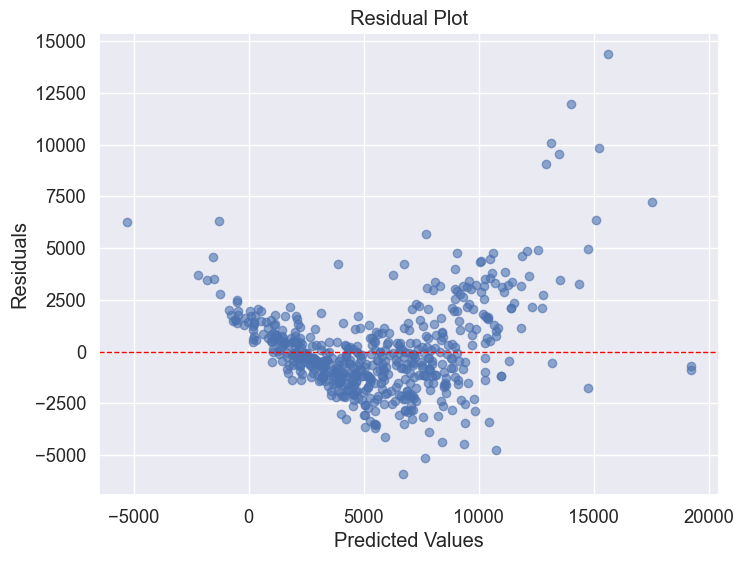

In [120]:
import matplotlib.pyplot as plt

residuals = y_val - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.show()


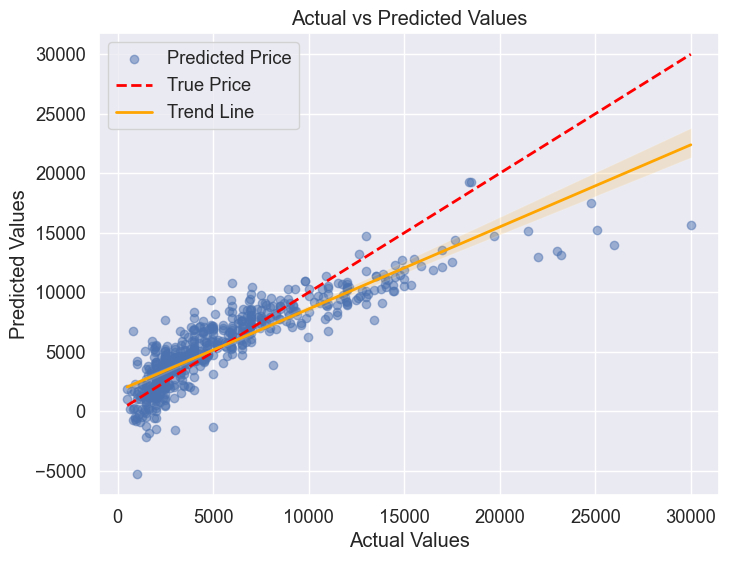

In [121]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.5, label='Predicted Price')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', linewidth=2, label='True Price')
sns.regplot(x=y_val, y=y_pred, scatter=False, color='r', line_kws={"color": "orange", "lw": 2}, label='Trend Line', ci=95)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.savefig('Linear Regression')
plt.show()



## Regularization

In [96]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import numpy as np

# Define the regularization strength values
alpha = [0.001,0.01,0.1,1,10,100,1000]

# Initialize lists to store results for analysis
results = []

# Iterate over different alpha values
for i in alpha:
    # Create the pipeline using make_pipeline with your preprocessor and Ridge regression
    model_pipeline = make_pipeline(
        preprocessor,  # Custom preprocessing steps
        Ridge(alpha=i)  # Ridge regression with specific alpha
    )
    
    # Fit the model
    model_pipeline.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model_pipeline.predict(X_val)
    RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    # Store results
    results.append({'alpha': i, 'RMSE': RMSE, 'R2': r2})
    
    # Print results for this alpha
    print(f'Alpha: {i}')
    print(f'Root Mean Square Error: {RMSE:.2f}')
    print(f'R2 Score: {r2:.4f}')
    print('-' * 50)

# Display all results in tabular format for better comparison
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


C:\Users\user\.virtualenvs\10-kubernetes-taEED_rI\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\user\.virtualenvs\10-kubernetes-taEED_rI\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Alpha: 0.001
Root Mean Square Error: 2173.65
R2 Score: 0.7651
--------------------------------------------------
Alpha: 0.01
Root Mean Square Error: 2171.59
R2 Score: 0.7655
--------------------------------------------------


C:\Users\user\.virtualenvs\10-kubernetes-taEED_rI\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\user\.virtualenvs\10-kubernetes-taEED_rI\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\user\.virtualenvs\10-kubernetes-taEED_rI\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Alpha: 0.1
Root Mean Square Error: 2170.73
R2 Score: 0.7657
--------------------------------------------------
Alpha: 1
Root Mean Square Error: 2193.82
R2 Score: 0.7607
--------------------------------------------------
Alpha: 10
Root Mean Square Error: 2260.92
R2 Score: 0.7458
--------------------------------------------------
Alpha: 100
Root Mean Square Error: 2382.10
R2 Score: 0.7178
--------------------------------------------------
Alpha: 1000
Root Mean Square Error: 2783.52
R2 Score: 0.6147
--------------------------------------------------
      alpha         RMSE        R2
0     0.001  2173.654315  0.765065
1     0.010  2171.593618  0.765510
2     0.100  2170.726537  0.765697
3     1.000  2193.816365  0.760686
4    10.000  2260.917699  0.745823
5   100.000  2382.100314  0.717846
6  1000.000  2783.520166  0.614739


C:\Users\user\.virtualenvs\10-kubernetes-taEED_rI\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\user\.virtualenvs\10-kubernetes-taEED_rI\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Result
Ridge improved the R2 Score from 0.76 to 0.784 and RMSE from 1941 to 1859

### RandomForestRegressor

In [97]:
# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
    preprocessor,  # Preprocessing steps
    RandomForestRegressor(random_state=1)
)

In [98]:
# Example: Fit the model pipeline with training data

model_pipeline.fit(X_train, y_train)

# Predict on new data
y_pred = model_pipeline.predict(X_val) 

C:\Users\user\.virtualenvs\10-kubernetes-taEED_rI\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [99]:
RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
r2=r2_score(y_val, y_pred)
print(f'Root Mean Square Error with validation data {RMSE}') 
print(f'R2 Score:{r2}')     #1500, 0.85  

Root Mean Square Error with validation data 1574.2106365960285
R2 Score:0.8767767888964733


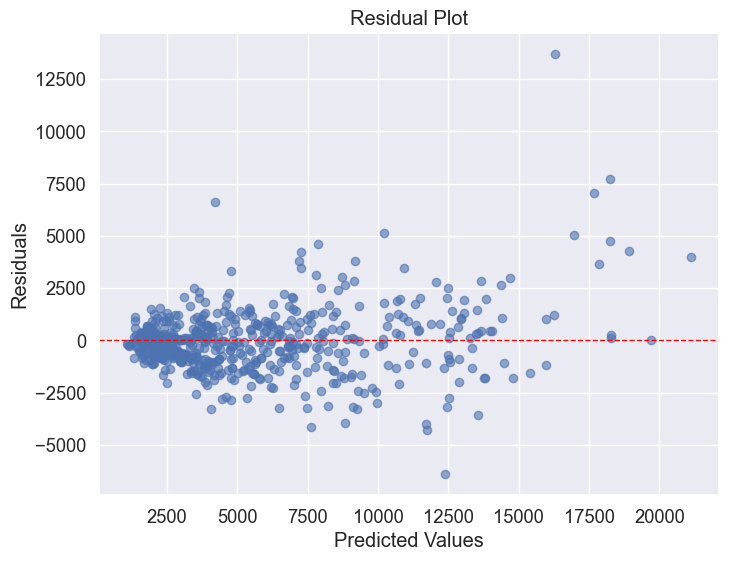

In [100]:
import matplotlib.pyplot as plt

residuals = y_val - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

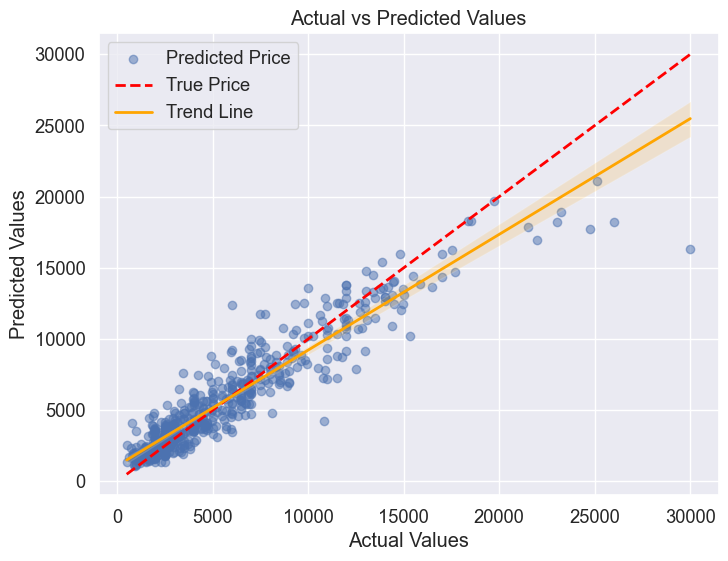

In [101]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.5, label='Predicted Price')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', linewidth=2, label='True Price')
sns.regplot(x=y_val, y=y_pred, scatter=False, color='r', line_kws={"color": "orange", "lw": 2}, label='Trend Line', ci=95)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.savefig('Random Regression')
plt.show()

In [94]:
scores=[]

for n_tree in range(50,401,20):
    # Create the pipeline using make_pipeline
    model_pipeline = make_pipeline(
        preprocessor,  # Preprocessing steps
        RandomForestRegressor(n_estimators=n_tree, random_state=1)
        )
    model_pipeline.fit(X_train, y_train)

    # Predict on new data
    y_pred = model_pipeline.predict(X_val) 
    RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
    r2=r2_score(y_val, y_pred)
    scores.append((n_tree, RMSE,r2))
    

C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserW

In [95]:
df_scores = pd.DataFrame(scores, columns=['n_estimator','rmse', 'r2'])
df_scores

,n_estimator,rmse,r2
0,50,1575.695537,0.876544
1,70,1579.285322,0.875981
2,90,1567.886984,0.877765
3,110,1578.409874,0.876119
4,130,1570.134316,0.877414
5,150,1576.832314,0.876366
6,170,1577.736413,0.876224
7,190,1576.710649,0.876385
8,210,1577.374194,0.876281
9,230,1579.131910,0.876005


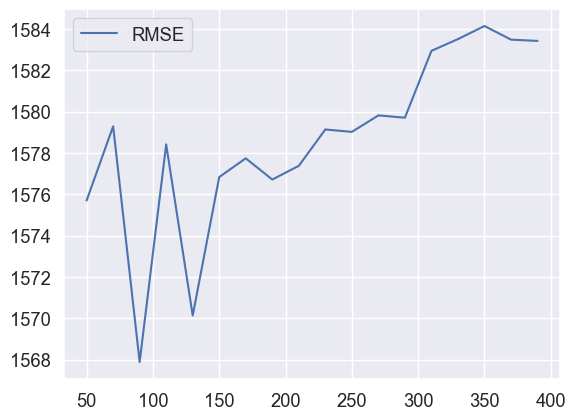

In [96]:
plt.plot(df_scores.n_estimator, df_scores.rmse, label='RMSE') # 
plt.legend();

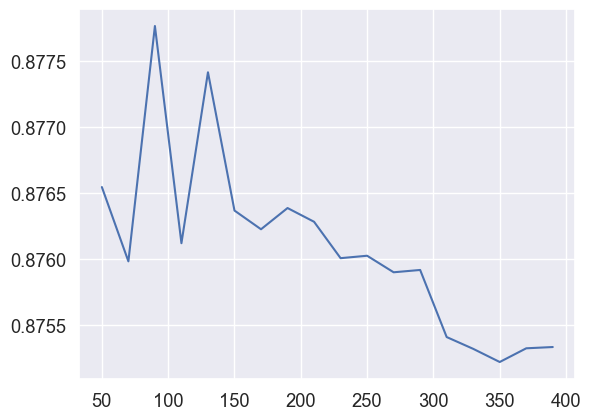

In [97]:
plt.plot(df_scores.n_estimator, df_scores.r2, label='R2') # best n estimator 90

In [98]:
import time
from tqdm import tqdm
scores = []
t0=time.time()
for d in tqdm(range(10,201,10)):     
    model_pipeline = make_pipeline(
    preprocessor,  # Preprocessing steps
    RandomForestRegressor(n_estimators=90,
                                max_depth=d,
                                random_state=1)
    )
    model_pipeline.fit(X_train, y_train)
    y_pred=model_pipeline.predict(X_val)
    RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
    r2=r2_score(y_val, y_pred)
    scores.append((d, RMSE,r2))
t1=time.time()
print((t1-t0)/60)

  0%|                                                                                                                | 0/20 [00:00<?, ?it/s]C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
  5%|█████▏                                                                                                  | 1/20 [00:04<01:27,  4.62s/it]C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 10%|██████████▍                                                                                             | 2/20 [00:14<02:17,  7.64s/it]C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in 

2.589946190516154


In [99]:
df_scores = pd.DataFrame(scores, columns=['max_depth','rmse', 'r2'])
df_scores

,max_depth,rmse,r2
0,10,1588.174690,0.874581
1,20,1555.881415,0.879630
2,30,1571.146156,0.877256
3,40,1567.886984,0.877765
4,50,1567.886984,0.877765
5,60,1567.886984,0.877765
6,70,1567.886984,0.877765
7,80,1567.886984,0.877765
8,90,1567.886984,0.877765
9,100,1567.886984,0.877765


In [100]:
#best  estimator 90 and depth 20

C:\Users\user\AppData\Local\Temp\ipykernel_21204\3791956883.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


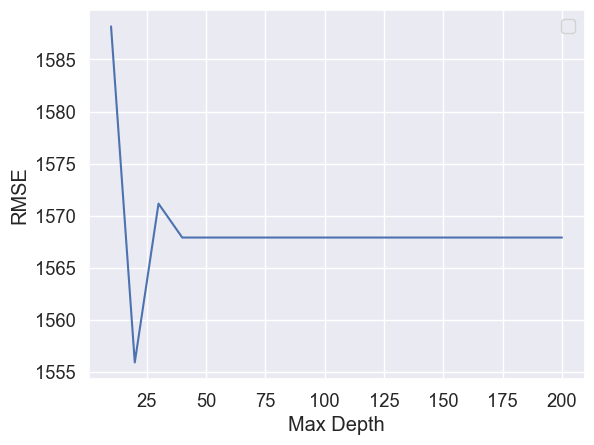

In [101]:

 
plt.plot(df_scores.max_depth, df_scores.rmse,
            
        )
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.legend();


C:\Users\user\AppData\Local\Temp\ipykernel_21204\3101057219.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


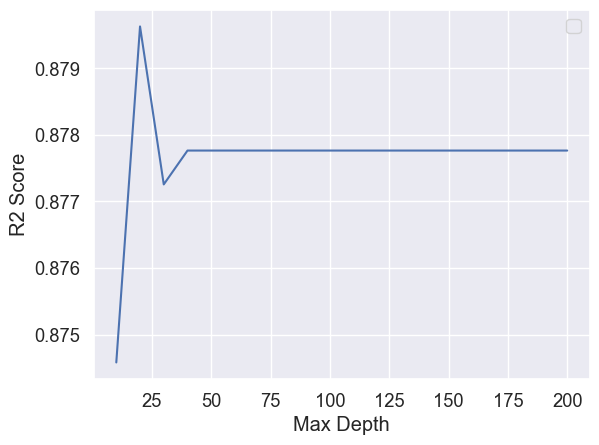

In [102]:
plt.plot(df_scores.max_depth, df_scores.r2,
            
        )
plt.xlabel('Max Depth')
plt.ylabel('R2 Score')
plt.legend();

## Final Training

In [103]:
# train with training and validation

model_pipeline = make_pipeline(
    preprocessor,  # Preprocessing steps
    RandomForestRegressor(n_estimators=90,
                                max_depth=20,
                                random_state=1)
    )
model_pipeline.fit(X_train_full, y_train_full)
y_pred=model_pipeline.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
r2=r2_score(y_test, y_pred)
print(f'R2 Score:{r2}\n RMSE:{RMSE}')

R2 Score:0.8535443489611007
 RMSE:1492.7879334868169


### Deep Learning


In [102]:
# Create the pipeline with scaling and MLPRegressor
model_pipeline = make_pipeline(
    preprocessor,  # Scaling the data
    MLPRegressor(hidden_layer_sizes=(128, 64), random_state=1, max_iter=10000, solver='adam',  learning_rate_init=0.001)  # MLPRegressor
)

# Fit the model
model_pipeline.fit(X_train, y_train)

# Predict using the trained model
y_pred = model_pipeline.predict(X_val)

# Evaluate the model
RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)  # R^2 Score
print(f'Root Mean Squared Error: {RMSE}')
print(f'R2 Score: {r2}')

Root Mean Squared Error: 1397.8188581114055
R2 Score: 0.902844223407251


C:\Users\user\.virtualenvs\10-kubernetes-taEED_rI\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


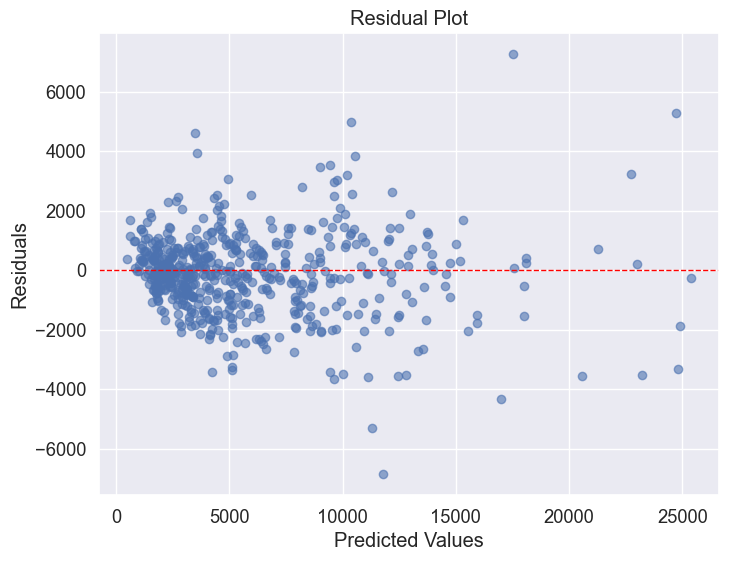

In [103]:
import matplotlib.pyplot as plt

residuals = y_val - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

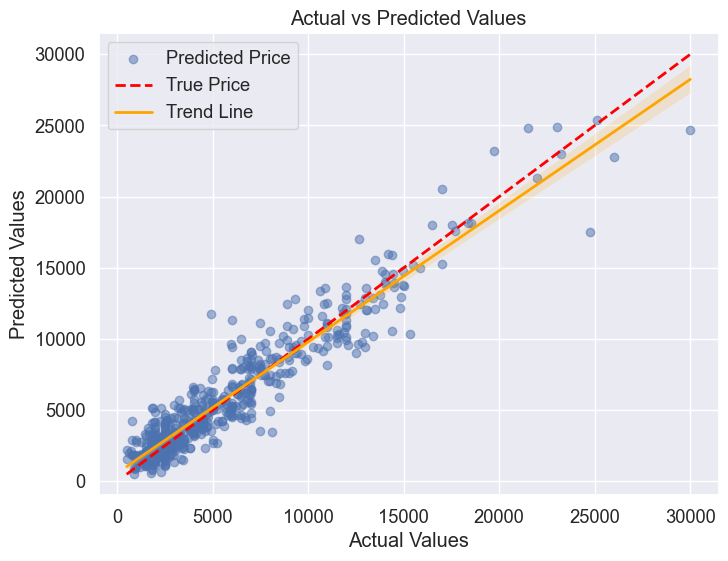

In [104]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.5, label='Predicted Price')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', linewidth=2, label='True Price')
sns.regplot(x=y_val, y=y_pred, scatter=False, color='r', line_kws={"color": "orange", "lw": 2}, label='Trend Line', ci=95)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.savefig('Neural Networks')
plt.show()

### Final Training with training and validation combined

In [105]:
# Create the pipeline with scaling and MLPRegressor
model_pipeline = make_pipeline(
    preprocessor,  # Scaling the data
    MLPRegressor(hidden_layer_sizes=(128, 64), random_state=1, max_iter=10000, solver='adam',  learning_rate_init=0.001)  # MLPRegressor
)

# Fit the model
model_pipeline.fit(X_train_full, y_train_full)

# Predict using the trained model
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)  # R^2 Score
print(f'Root Mean Squared Error: {RMSE}')
print(f'R2 Score: {r2}')

Root Mean Squared Error: 1332.135039912204
R2 Score: 0.8833710392437837


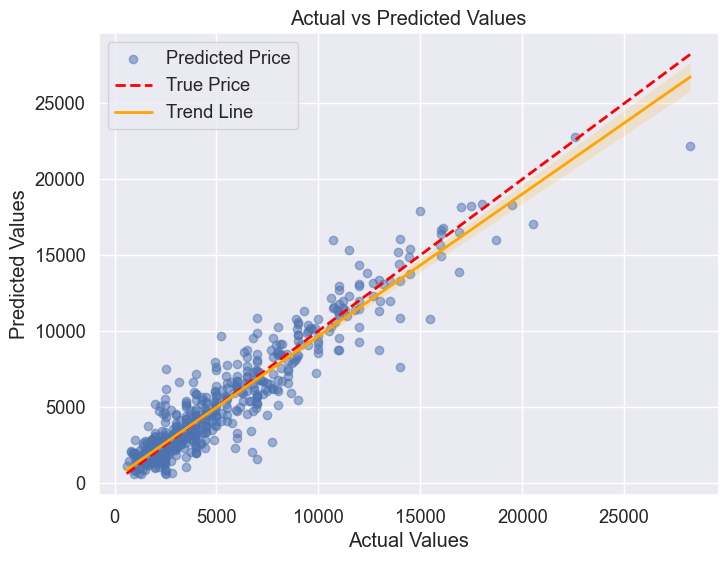

In [109]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted Price')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2, label='True Price')
sns.regplot(x=y_test, y=y_pred, scatter=False, color='r', line_kws={"color": "orange", "lw": 2}, label='Trend Line', ci=95)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.savefig('Neural Network Final')
plt.show()


In [107]:
import pickle  # Import the pickle module

# ... (previous code remains the same)


best_model = model_pipeline

# Save the best model to a file using pickle
with open('car_price_predictor/best_neural_network.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Best model saved to 'best_neural_network.pkl'")


Best model saved to 'best_neural_network.pkl'


In [108]:
# To load the saved model
with open('car_price_predictor/best_neural_network.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Use the loaded model to make predictions
y_pred = loaded_model.predict(X_test)
#y_pred
print(loaded_model)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['unknown',
                                                                              'full'],
                                                                             ['euro_1',
                                                                              'euro_2',
                                                                              'euro_3',
                                                                              'euro_4',
                                                                              'euro_5',
                                                                              'euro_6'],
                                                                             ['0.8l',
                                                                              '0.9l',
                        